In [1]:
from ftplib import FTP
import os
import zipfile
#import gzip
#import tarfile
from pprint import pprint
import io
import pandas
import numpy as np
import time
from IPython.display import display, HTML
import geopandas
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker

from shapely.ops import unary_union
from shapely.geometry import Point, Polygon, box
from matplotlib.patches import FancyBboxPatch, BoxStyle
import re
from matplotlib.path import Path

read_smaller_states = True

# #these_states_dict = {'FL': {}, 'MD': {}}
these_states_dict = {
    'NY': {},
            }

g = 0
scale = 20
map_buffer_ratio = .1
main_map_crs = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs "
alaska_crs = "epsg:3338"
hawaii_crs = "+proj=tmerc +lat_0=21.16666666666667 +lon_0=-158 +k=0.99999 +x_0=500000.0000000002 +y_0=0 +datum=NAD83 +units=us-ft +no_defs "

equal_area_crs = 2163  # An equal area projection: https://epsg.io/2163
absolute_overlap_tol = 100    # tolerance for declaring areas overlapping, in sq meters
desired_pct_area_overlap = 0.5     # relative overlap to declare something a match

show_water = True
show_roads = True



water_area_tol = .5 * 1000 * 1000

#print('Target: each district should contain {0:,.0f} people!'.format(target))
print('ok')

ok


In [2]:
s = time.time()
script_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/'
census_script_dir = '/home/idies/workspace/Storage/raddick/census/'
basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/redistricting/2020/'
shapefile_basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/2020/'
extras_dir = '/home/idies/workspace/Storage/raddick/census/extras/'

district_color_cycle = ['black', 'red', 'green', 'orange', 'cyan', 'yellow', 'pink', 'gray', 'lime', 'navajowhite', 'cornflowerblue', 'darkseagreen', 'thistle', 'tomato', 'silver', 'blueviolet', 'olive', 'peru', 'dodgerblue']
#district_color_cycle = ['black', 'red', 'green', 'orange', 'cyan', 'yellow', 'pink', 'gray', 'lime', 'navajowhite', 'cornflowerblue', 'darkseagreen', 'thistle', 'purple', 'silver', 'blueviolet', 'olive', 'peru', 'dodgerblue']
district_color_cycle += district_color_cycle
district_color_cycle += district_color_cycle

district_contrast_color_cycle = ['black', 'green', 'red', 'navy', 'black', 'purple', 'lime', 'black', 'red', 'red', 'black', 'red', 'black', 'black', 'white', 'yellow', 'yellow', 'yellow', 'yellow']
district_contrast_color_cycle += district_contrast_color_cycle
district_contrast_color_cycle += district_contrast_color_cycle

os.chdir(basedir)
e = time.time()
g += (e-s)
print('Now in directory: {0:}'.format(basedir))

Now in directory: /home/idies/workspace/Temporary/raddick/census_scratch/redistricting/2020/


In [3]:
print('setting up infrastructure to plot roads...')
# we may derive from matplotlib.patches.BoxStyle._Base class.
# You need to override transmute method in this case.
class shield(BoxStyle._Base):
    """
    A simple box.
    """

    def __init__(self, pad=0.3):
        """
        The arguments need to be floating numbers and need to have
        default values.

         *pad*
            amount of padding
        """

        self.pad = pad
        super().__init__()

    def transmute(self, x0, y0, width, height, mutation_size):
        """
        Given the location and size of the box, return the path of
        the box around it.

         - *x0*, *y0*, *width*, *height* : location and size of the box
         - *mutation_size* : a reference scale for the mutation.

        Often, the *mutation_size* is the font size of the text.
        You don't need to worry about the rotation as it is
        automatically taken care of.
        """

        # padding
        pad = mutation_size * self.pad

        # width and height with padding added.
        width, height = width + 2.*pad, \
                        height + 2.*pad,

        # boundary of the padded box
        x0, y0 = x0-pad, y0-pad,
        x1, y1 = x0+width, y0 + height

        cp = [(0.5*(x0+x1), (y0-2.*pad)), # bottom
              (x1, y0),  # right lower-mid
              (x1+pad, (y0+y1)/2.),  # far right mid
              (x1, y1+pad),  # top right corner
              ((x0+x1)/2,y1),  # dip from top
              (x0, y1+pad),  # top left corner
              (x0-pad, (y0+y1)/2.),    # far left mid
              (x0, y0),  # left lower-mid
              ((x0+x1)/2., (y0-2.*pad)),  # return to bottom
              ((x0+x1)/2., (y0-2.*pad))]
        
        
        com = [Path.MOVETO,  # start
               Path.CURVE4, # curve to right mid
               Path.LINETO,  # line to far right mid
               Path.LINETO, # line to top right corner
               Path.CURVE3,  # line to dip
               Path.LINETO,  # line to top left corner
               Path.CURVE4,   # curve to far left mid
               Path.LINETO,   # line to left lower-mid
               Path.LINETO,
               Path.CLOSEPOLY]

        path = Path(cp, com)

        return path

BoxStyle._style_list["shield"] = shield



def parse_road_name(thename):
    try:
        annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
        if ('Con' in annotator):
            annotator = '{0:}-C'.format(annotator[:-4])
    except AttributeError:
        try: 
            annotator = thisrow['FULLNAME'][re.search('Hwy',thisrow['FULLNAME']).end():]
        except AttributeError:
            annotator = thisrow['FULLNAME']
    return annotator


road_label_format = { 
    'I': { 'labelsize': 18, 'thecolor': 'orange', 'thebbox': dict(boxstyle="shield", fc='blue', ec='orange'), 'labelcolor': 'white'},     
    'U': { 'labelsize': 16, 'thecolor': 'black', 'thebbox': dict(boxstyle="shield", fc='white', ec='black'), 'labelcolor': 'black'},
    'S': { 'labelsize': 15, 'thecolor': 'black', 'thebbox': dict(boxstyle="square,pad=0.25", fc='white', ec='black'), 'labelcolor': 'black'},
    'C': { 'labelsize': 14, 'thecolor': 'black', 'thebbox': dict(boxstyle="sawtooth,pad=0.5", fc='white'), 'labelcolor': 'black'}, 
    'M': { 'labelsize': 16, 'thecolor': 'black', 'labelcolor': 'black'},
    'O': { 'labelsize': 11, 'thecolor': 'black', 'labelcolor': 'black'},
    'x': { 'labelsize': 10, 'thecolor': 'gray', 'labelcolor': 'gray'},
}
print('Done!')



setting up infrastructure to plot roads...
Done!


In [4]:
s = time.time()
# print('Getting data from FTP...')

# ftp = FTP('ftp2.census.gov')
# ftp.login()
# print(ftp.getwelcome())

# ftp.cwd('programs-surveys/decennial/2020/data/01-Redistricting_File--PL_94-171/')
# for thisdir in [x for x in ftp.nlst() if (('.pdf' not in x) and ('.doc' not in x))]:
#     print('Retrieving {0:}...'.format(thisdir))
#     zipfiles = [x for x in ftp.nlst(thisdir)]
#     for thisfile in zipfiles:
#         with io.open(thisfile.split('/')[1].lower(), 'wb') as f:
#              ftp.retrbinary('RETR {0:}'.format(thisfile), f.write)
# ftp.quit()
# print('Done')

# os.listdir()
#os.getcwd()
e = time.time()
g += (e-s)
#print('Done in {0:.1f} seconds!'.format(e-s))
print('Retrieved files from Census FTP!')

Retrieved files from Census FTP!


In [5]:
s = time.time()
# for thisfile in os.listdir():
#     with zipfile.ZipFile(thisfile, 'r') as z:
#         print('Extracting {0:}...'.format(thisfile))
#         z.extractall()
# for thisfile in [x for x in os.listdir() if ('zip' in x)]:
#     os.remove(thisfile)
# print('Done!')
e = time.time()
g += (e-s)
#print('Done in {0:.1f} seconds!'.format(e-s))
print('Unzipped files!')

Unzipped files!


# How many districts per state?

In [6]:
state_seats_df = pandas.read_csv(script_dir+'state_seats.csv', index_col='state_name')

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
#state_codes_df.columns = [x.lower() for x in state_codes_df.columns]
state_codes_df = state_codes_df.set_index('STATE_NAME')

#bg_df = bg_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

# state_seats_df = state_seats_df.reset_index().merge(
#     geo_df[geo_df['SUMLEV'] == 40][['STATE', 'STUSAB', 'NAME']], how='left', 
#     left_on='state_name', right_on='NAME'
# )[['STATE', 'STUSAB', 'seats_old', 'seats_new']].set_index('STATE').sort_index()

# print('Found new numbers of districts for {0:,.0f} states!'.format(len(state_seats_df)))
#state_seats_df
#geo_df[geo_df['SUMLEV'] == 40][['STATE', 'STUSAB', 'NAME']]

state_seats_df = state_seats_df.join(state_codes_df).set_index('STATE').sort_index()

print('Got old and new numbers of districts for {0:,.0f} states in {1:.1f} seconds!'.format(len(state_seats_df), e-s))

for this_state in these_states_dict.keys():
    these_states_dict[this_state]['STATEFP'] = state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]    
    these_states_dict[this_state]['seats_old'] = state_seats_df[state_seats_df['STUSAB'] == this_state]['seats_old'].values[0]
    these_states_dict[this_state]['seats_new'] = state_seats_df[state_seats_df['STUSAB'] == this_state]['seats_new'].values[0]
#pprint(these_states_dict)
print('\n')
print('Got old and new numbers of districts for {0:,.0f} focus states in {1:.1f} seconds!'.format(len(these_states_dict), e-s))



looking up state names from numbers...
Got old and new numbers of districts for 50 states in 0.0 seconds!


Got old and new numbers of districts for 1 focus states in 0.0 seconds!


# Read summary levels

In [7]:
s = time.time()
print('setting up summary levels...')
sumlevel_df = pandas.read_excel(script_dir+'sumlevel.xlsx')
sumlevel_df = sumlevel_df.rename(columns={'sumlevel': 'SUMLEV'})
sumlevel_df.index.name = 'rownumber'
#sumlevel_df = sumlevel_df.set_index('SUMLEV')
e = time.time()
g += (e-s)
print('Read descriptions for {0:,.0f} summary levels in {1:.1f} seconds!'.format(len(sumlevel_df), e-s))
#sumlevel_df


setting up summary levels...
Read descriptions for 85 summary levels in 0.1 seconds!


# Read redistricting geo data

In [8]:
s = time.time()
print('reading redistricting geography data for all states...')
geofiles = []

allgeofiles = [x for x in os.listdir() if (('geo' in x) and (x[-3:] == '.pl') and (x[:2] not in ['dc', 'pr', 'mp', 'vi', 'as', 'gu']))]
for this_focus_state in list(these_states_dict.keys()):
    geofiles += [x for x in allgeofiles if x[0:2] == this_focus_state.lower()]
    #geofiles.append([x for x in geofiles if x[0:2] == this_focus_state.lower()])

geo_df = pandas.DataFrame()

for thisfile in geofiles:
    print('\treading {0:}...'.format(thisfile))
    geo_df_i = pandas.read_csv(thisfile, sep='|', header=None, low_memory=False, encoding='ISO-8859-1')#, encoding='utf-8')
    geo_df = pandas.concat((geo_df, geo_df_i), axis=0)
    
print('renaming columns...')
column_names = []
column_names += ['FILEID', 'STUSAB', 'SUMLEV', 'GEOVAR', 'GEOCOMP', 'CHARITER', 'CIFSN', 'LOGRECNO', 'GEOID']
column_names += ['GEOCODE', 'REGION', 'DIVISION', 'STATE', 'STATENS', 'COUNTY', 'COUNTYCC', 'COUNTYNS']
column_names += ['COUSUB', 'COUSUBCC', 'COUSUBNS']
column_names += ['SUBMCD', 'SUBMDCC', 'SUBMCDNS', 'ESTATE', 'ESTATECC', 'ESTATENS']
column_names += ['CONCIT', 'CONCITCC', 'CONCITNS', 'PLACE','PLACECC', 'PLACENS']
column_names += ['TRACT', 'BLKGRP', 'BLOCK']
column_names += ['AIANHH', 'AIANHHLI', 'AIANHHFP', 'AIANHHCC', 'AIANHHNS', 'AITS', 'AITSFP', 'AITSCC', 'AITSNS']
column_names += ['TTRACT', 'TBLKGRP', 'ANRC', 'ANRCCC', 'ARNCNS']
column_names += ['CBSA', 'MEMI', 'CSA', 'METDIV']
column_names += ['NECTA', 'NMEMI', 'CNECTA', 'NECTADIV']
column_names += ['CBSAPCI', 'NECTAPCI', 'UA', 'UATYPE', 'UR']
column_names += ['CD116', 'CD118', 'CD119', 'CD120', 'CD121']
column_names += ['SLDU18', 'SLDU22', 'SLDU24', 'SLDU26', 'SLDU28']
column_names += ['SLDL18', 'SLDL22', 'SLDL24', 'SLDL26', 'SLDL28']
column_names += ['VTD', 'VTDI', 'ZCTA', 'SDELM', 'SDSEC', 'SDUNI', 'PUMA']
column_names += ['AREALAND', 'AREAWATER', 'BASENAME', 'NAME', 'FUNCSTAT', 'GCUNI']
column_names += ['POP100', 'HU100']
column_names += ['INTPTLAT', 'INTPTLON', 'LSADC', 'PARTFLAG', 'UGA']

# for i in range(0, len(column_names)):    
#     if (np.isnan(pandas.to_numeric(column_names[i], errors='coerce'))):
#         geo_df = geo_df.rename(columns = {i: column_names[i]})
#     else:
#         geo_df = geo_df.rename(columns = {i: int(column_names[i])})

geo_df.columns = column_names

print('\tTotal columns: {0:.0f}'.format(len(geo_df.columns)))
print('\tNamed columns: {0:.0f}'.format(len(column_names)))

geo_df = geo_df.set_index('GEOID')


# print('finding stuff...')
# mycol = 'UGA'
# showcolumns = []
# showcolumns += ['SUMLEV', mycol]
#geo_df[geo_df[mycol].notnull()][showcolumns]
#print('done')

# geo_df.merge(sumlevel_df, how='left', on='SUMLEV')
# geo_df.set_index('SUMLEV')
# print('adding summary level descriptions...')
# geo_df = geo_df.reset_index().merge(sumlevel_df, how='left', on='SUMLEV').set_index('GEOID')
# geo_df = geo_df.rename(columns={'description': 'sumlev_description'})

#geo_df
e = time.time()
g += (e-s)
print('\n')
print('Read {0:,.0f} geographies in {1:.0f} minutes {2:.0f} seconds!'.format(len(geo_df), np.floor((e-s)/60), (e-s)%60))


reading redistricting geography data for all states...
	reading nygeo2020.pl...
renaming columns...
	Total columns: 97
	Named columns: 97


Read 573,374 geographies in 0 minutes 21 seconds!


In [9]:
s = time.time()
print('counting by summary level...')
count_df = pandas.DataFrame(data=None, columns=['sumlev_description', 'count', 'pop'], index=sumlevel_df['SUMLEV'].tolist())
count_df.index.name = 'SUMLEV'
count_df.loc[:, 'sumlev_description'] = sumlevel_df.set_index('SUMLEV')['description']
count_df.loc[:, 'count'] = geo_df.groupby('SUMLEV').size()
count_df.loc[:, 'pop'] = geo_df.groupby('SUMLEV')['POP100'].sum()
#count_df
nan_levels = count_df[count_df['count'].isnull()].index.tolist()

htmlstr = ''
htmlstr += '<table>'
htmlstr += '<tr>'
htmlstr += '<th>SUMLEVEL</th>'
for thiscol in count_df.columns.tolist():    
    htmlstr += '<th>{0:}</th>'.format(thiscol)
htmlstr += '</tr>'

for sumlev, thisrow in count_df.iterrows():
    #if ('remainder' not in thisrow['sumlev_description'].lower()):
    if (sumlev not in nan_levels):
        htmlstr += '<tr>'    
        htmlstr += '<td>{0:3d}</td><td>{1:}</td><td>{2:,.0f}</td><td>{3:,.0f}</td>'.format(sumlev, thisrow['sumlev_description'], thisrow['count'], thisrow['pop'])
        htmlstr += '</tr>'
htmlstr += '</table>'

# print('No data for these columns: {0:}'.format(nan_levels))
# display(HTML(htmlstr))

e = time.time()
g += (e-s)
print('\n')
print('Documented {0:,.0f} geographies in {1:.1f} seconds!'.format(len(count_df), e-s))



counting by summary level...


Documented 85 geographies in 0.1 seconds!


In [10]:
s = time.time()
print('Getting current Congressional District data...')
cd_df = geo_df[geo_df['SUMLEV'] == 500]
cd_df = cd_df[cd_df['CD116'] != 'ZZ']
cd_df.loc[:, 'CD116'] = pandas.to_numeric(cd_df['CD116'], errors='coerce')
cd_df.loc[cd_df['CD116'] == 0, 'CD116'] = 1

print('adding shapefiles...')
gdf = geopandas.read_file(shapefile_basedir+'CD/tl_2020_us_cd116.shp')
gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '5001600US'+x)
gdf = gdf.set_index('GEOID')

cd_gdf = geopandas.GeoDataFrame(data=cd_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')
#cd_gdf

e = time.time()
g += (e-s)
print('\n')
print('Joined {0:,.0f} congressional districts to shapefiles in {1:.1f} seconds!'.format(len(cd_gdf), e-s))
#cd_gdf[['STATE', 'STUSAB']].drop_duplicates()
#cd_gdf.plot()
# print(cd_gdf.groupby('CD116')['POP100'].sum())
# print('\n')
# print(cd_gdf.groupby('STUSAB')['POP100'].sum())
# print('\n')
# print('{0:,.0f}'.format(cd_gdf['POP100'].sum()))


Getting current Congressional District data...
adding shapefiles...


Joined 27 congressional districts to shapefiles in 3.9 seconds!


In [11]:
print('getting tract data...')
s = time.time()
tract_df = geo_df[geo_df['SUMLEV'] == 140]
tract_df = tract_df.assign(census_tract = tract_df['TRACT'].apply(lambda x: x/100))
#tract_df[['SUMLEV', 'STATE', 'STUSAB', 'COUNTY', 'census_tract', 'BLKGRP', 'NAME']].sample(3)

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
tract_df = tract_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')


print('looking up county names from numbers...')
county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATE', 'County Code (FIPS)': 'COUNTY', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
county_names_df = county_names_df.reset_index(drop=True)
tract_df = tract_df.reset_index().merge(county_names_df[['STATE', 'COUNTY', 'COUNTY_NAME']], how='left', on=['STATE', 'COUNTY']).set_index('GEOID')

print('adding empty column for new districts...')
tract_df = tract_df.assign(new_district = np.nan)

print('adding shapefiles...')
gdf = geopandas.GeoDataFrame()
for this_state in tract_df['STATE'].drop_duplicates().tolist():
    print('\tgetting shapefiles for {0:}...'.format(state_codes_df[state_codes_df['STATE'] == this_state]['STUSAB'].values[0]))
    gdf_i = geopandas.read_file(shapefile_basedir+'TRACT/tl_2020_{0:02d}_tract.shp'.format(this_state))
    #print('\t\t{0:} CRS = {1:}'.format(this_state, gdf_i.crs))
    gdf = pandas.concat((gdf, gdf_i), axis=0)
gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '1400000US'+x)
gdf = gdf.set_index('GEOID')
tract_gdf = geopandas.GeoDataFrame(data=tract_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')


#state_codes_df
#tract_df = tract_gdf.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

e = time.time()
g += (e-s)
print('\n')
print('Joined {0:,.0f} tracts to shapefiles in {1:.1f} seconds!'.format(len(tract_gdf), e-s))



getting tract data...
looking up state names from numbers...
looking up county names from numbers...
adding empty column for new districts...
adding shapefiles...
	getting shapefiles for NY...


Joined 5,411 tracts to shapefiles in 11.1 seconds!


In [12]:
# print('getting block group data...')
# s = time.time()
# bg_df = geo_df[geo_df['SUMLEV'] == 150]
# bg_df = bg_df.assign(census_tract = bg_df['TRACT'].apply(lambda x: x/100))
# #bg_df[['SUMLEV', 'STATE', 'STUSAB', 'COUNTY', 'census_tract', 'BLKGRP', 'NAME']].sample(3)

# print('looking up state names from numbers...')
# state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
# bg_df = bg_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')


# print('looking up county names from numbers...')
# county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
# county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
# county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATE', 'County Code (FIPS)': 'COUNTY', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
# county_names_df = county_names_df.reset_index(drop=True)
# bg_df = bg_df.reset_index().merge(county_names_df[['STATE', 'COUNTY', 'COUNTY_NAME']], how='left', on=['STATE', 'COUNTY']).set_index('GEOID')

# print('adding empty column for new districts...')
# bg_df = bg_df.assign(new_district = np.nan)

# print('adding shapefiles...')
# gdf = geopandas.GeoDataFrame()
# for this_state in bg_df['STATE'].drop_duplicates().tolist():
#     print('\tgetting shapefiles for {0:}...'.format(state_codes_df[state_codes_df['STATE'] == this_state]['STUSAB'].values[0]))
#     gdf_i = geopandas.read_file(shapefile_basedir+'BG/tl_2020_{0:02d}_bg.shp'.format(this_state))
#     print('\t\t{0:} CRS = {1:}'.format(this_state, gdf_i.crs))
#     gdf = pandas.concat((gdf, gdf_i), axis=0)
# gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '1500000US'+x)
# gdf = gdf.set_index('GEOID')
# bg_gdf = geopandas.GeoDataFrame(data=bg_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')




# #state_codes_df
# #bg_df = bg_gdf.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

# e = time.time()
# g += (e-s)
# print('\n')
# print('Joined {0:,.0f} block groups to shapefiles in {1:.1f} seconds!'.format(len(bg_gdf), e-s))




In [13]:
s = time.time()
this_state = 'NY'

state_numbers_include_list = cd_gdf['STATE'].drop_duplicates().tolist()
state_numbers_include_list = ['{0:02d}'.format(x) for x in state_numbers_include_list]

print('getting states...')
state_gdf = geopandas.read_file(shapefile_basedir+'tl_2020_us_state.shp')
state_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(state_gdf['INTPTLON'])
state_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(state_gdf['INTPTLAT'])
state_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(state_gdf['STATEFP'], errors='coerce')
#state_gdf = state_gdf[state_gdf['STATEFP'].isin(state_numbers_include_list)]
state_gdf = state_gdf.set_index('GEOID')

print('getting counties...')
county_gdf = geopandas.read_file(shapefile_basedir+'tl_2020_us_county.shp')
county_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(county_gdf['STATEFP'], errors='coerce')
county_gdf.loc[:, 'COUNTYNS'] = pandas.to_numeric(county_gdf['COUNTYNS'], errors='coerce')
county_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(county_gdf['INTPTLON'])
county_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(county_gdf['INTPTLAT'])
#county_gdf = county_gdf[county_gdf['STATEFP'].isin(state_numbers_include_list)]
county_gdf = county_gdf.set_index('GEOID')

e = time.time()
g += (e-s)
print('Got {0:,.0f} states and {1:,.0f} counties in {2:.1f} seconds!'.format(len(state_gdf), len(county_gdf), e-s))
print('\n')


if (show_water):
    print('getting water areas...')

    waterfiles = [shapefile_basedir+'AREAWATER/'+x for x in os.listdir(shapefile_basedir+'AREAWATER/') if ((x[-4:] == '.shp') )]
    state_numbers_include_list = cd_gdf['STATE'].drop_duplicates().tolist()
    state_numbers_include_list = ['{0:02d}'.format(x) for x in state_numbers_include_list]

    waterfiles = [x for x in waterfiles if x[89:91] in state_numbers_include_list]

    water_gdf = geopandas.GeoDataFrame()

    for i in range(0, len(waterfiles)):
        if (np.mod(i, 10) == 0):
            print('\treading water file {0:,.0f} of {1:,.0f}...'.format(i, len(waterfiles)))
        water_gdf_i = geopandas.read_file(waterfiles[i])
        water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
        water_gdf_i = water_gdf_i.assign(STUSAB = state_codes_df[state_codes_df['STATE'] == int(waterfiles[i][89:91])]['STUSAB'].values[0])
        water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0)
    water_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(water_gdf['INTPTLON'], errors='coerce')
    water_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(water_gdf['INTPTLAT'], errors='coerce')
    water_gdf = water_gdf.set_index('HYDROID')
    
    e = time.time()
    g += (e-s)

    print('Got {0:,.0f} water areas in {1:.0f} minutes {2:.1f} seconds!'.format(len(water_gdf), np.floor((e-s)/60), (e-s)%60))
    print('\n')


s = time.time()
print('getting CBSAs (metro areas)...')
cbsa_gdf = geopandas.read_file(shapefile_basedir+'CBSA/tl_2020_us_cbsa.shp')
cbsa_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(cbsa_gdf['INTPTLON'])
cbsa_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(cbsa_gdf['INTPTLAT'])
cbsa_gdf.loc[:, 'MEMI'] = pandas.to_numeric(cbsa_gdf['MEMI'])
cbsa_gdf = cbsa_gdf.set_index('GEOID')

print('\tFinding populations of CBSAs...')
cbsa_gdf = cbsa_gdf.assign(POP100 = np.nan)
for ix, thisrow in cbsa_gdf.sort_values(by='NAME').iterrows():
    cbsa_gdf.loc[ix, 'POP100'] = tract_gdf[(tract_gdf['COUNTYNS'].isin(county_gdf[county_gdf.geometry.within(thisrow.geometry)]['COUNTYNS'].tolist()))]['POP100'].sum()
    if (this_state in thisrow['NAME']):
        print('\t\t{0:} (n = {1:,.0f})...'.format(thisrow['NAME'], cbsa_gdf.loc[ix]['POP100']))
cbsa_gdf.loc[cbsa_gdf[cbsa_gdf['POP100'] == 0].index.tolist(), 'POP100'] = np.nan

e = time.time()
g += (e-s)
print('Got {0:,.0f} CBSAs in {1:.1f} seconds!'.format(len(cbsa_gdf), e-s))
print('\n')
s = time.time()
print('getting places...')
placefiles = [shapefile_basedir+'PLACE/'+x for x in os.listdir(shapefile_basedir+'PLACE/') if ((x[-4:] == '.shp'))]
placefiles = [x for x in placefiles if x[85:87] in state_numbers_include_list]

place_gdf = geopandas.GeoDataFrame()

for i in range(0, len(placefiles)):
    if (np.mod(i, 5) == 0):
        print('\treading place file {0:,.0f} of {1:,.0f}...'.format(i, len(placefiles)))
    place_gdf_i = geopandas.read_file(placefiles[i])
    place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0)
place_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(place_gdf['STATEFP'])
place_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(place_gdf['INTPTLON'])
place_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(place_gdf['INTPTLAT'])

place_gdf.loc[:, 'GEOID'] = place_gdf['GEOID'].apply(lambda x: '1600000US'+x)
place_gdf = place_gdf.set_index('GEOID')
e = time.time()
g += (e-s)
print('Got {0:,.0f} places in {1:.1f} seconds!'.format(len(place_gdf), e-s))
print('\n')

if (show_roads):
    print('getting roads...')
    roads_gdf = geopandas.GeoDataFrame()
#    print(os.listdir(shapefile_basedir+'ROADS/'))
    roads_file_list = [shapefile_basedir+'ROADS/'+x for x in os.listdir(shapefile_basedir+'ROADS/') if ((x[-4:] == '.shp') and (x[8:10] in state_numbers_include_list))]# and ('_{0:02d}'.format()))]# and ('tl_2018_{0:02d}'.format(this_state_number) in x))]
    for i in range(0, len(roads_file_list)):
        if ((np.mod(i,10) == 0) | (i == len(roads_file_list)-1)):
            print('\tReading road file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
        roads_gdf_i = geopandas.read_file(roads_file_list[i])    
        roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)
    roads_gdf = roads_gdf.set_index('LINEARID')
    e = time.time()
    g += (e-s)
    print('Got {0:,.0f} roads in {1:.0f} minutes {2:.1f} seconds!'.format(len(roads_gdf), np.floor((e-s)/60), (e-s)%60))
    print('\n')


print('Done!')


cbsa_gdf[cbsa_gdf['NAME'].apply(lambda x: this_state in x)][['NAME', 'POP100']].sort_values(by='POP100', ascending=False)


getting states...
getting counties...
Got 56 states and 3,234 counties in 6.2 seconds!


getting water areas...
	reading water file 0 of 62...
	reading water file 10 of 62...
	reading water file 20 of 62...
	reading water file 30 of 62...
	reading water file 40 of 62...
	reading water file 50 of 62...
	reading water file 60 of 62...
Got 939 water areas in 0 minutes 14.9 seconds!


getting CBSAs (metro areas)...
	Finding populations of CBSAs...
		Albany-Schenectady-Troy, NY (n = 899,262)...
		Amsterdam, NY (n = 49,532)...
		Auburn, NY (n = 76,248)...
		Batavia, NY (n = 58,388)...
		Binghamton, NY (n = 247,138)...
		Buffalo-Cheektowaga, NY (n = 1,166,902)...
		Corning, NY (n = 93,584)...
		Cortland, NY (n = 46,809)...
		Elmira, NY (n = 84,148)...
		Glens Falls, NY (n = 127,039)...
		Gloversville, NY (n = 53,324)...
		Hudson, NY (n = 61,570)...
		Ithaca, NY (n = 105,740)...
		Jamestown-Dunkirk-Fredonia, NY (n = 127,657)...
		Kingston, NY (n = 181,851)...
		Malone, NY (n = 47,555)...
		New

,NAME,POP100
GEOID,,
35620,"New York-Newark-Jersey City, NY-NJ-PA",13166338.0
15380,"Buffalo-Cheektowaga, NY",1166902.0
40380,"Rochester, NY",1090135.0
10580,"Albany-Schenectady-Troy, NY",899262.0
39100,"Poughkeepsie-Newburgh-Middletown, NY",697221.0
45060,"Syracuse, NY",662057.0
46540,"Utica-Rome, NY",292264.0
13780,"Binghamton, NY",247138.0
28740,"Kingston, NY",181851.0


In [14]:

# s = time.time()
# print('setting up insets...')
# insets = {}

# insets['se'] = {}
# insets['se']['how'] = 'districts'
# insets['se']['bounds'] = [-80.48, 25.54, -80, 26.84]
# insets['se']['axes_position'] = [0.3, 0.01]
# insets['se']['axes_rel_size'] = .255
# insets['se']['districts'] = [21,22,23,24,27]
# insets['se']['partial_districts'] = [18,20,25,26]
# insets['se']['counties'] = ['Palm Beach County', 'Broward County', 'Miami-Dade County']
# insets['se']['title'] = 'Southeast Florida'
# insets['se']['titlesize'] = 22
# insets['se']['borderwidth'] = 3

# insets['tpa'] = {}
# insets['tpa']['how'] = 'districts'
# #insets['tpa']['bounds'] = [-82.85, 27.6, -82, 28.2]
# insets['tpa']['bounds'] = [-82.9, 27.6, -82.18, 28.2]
# insets['tpa']['axes_position'] = [0.03, 0.015]
# insets['tpa']['axes_rel_size'] = 0.255
# insets['tpa']['districts'] = [13,14]
# insets['tpa']['partial_districts'] = [12, 15, 16]
# insets['tpa']['counties'] = ['Hillsborough County', 'Pinellas County']
# insets['tpa']['title'] = 'Tampa Bay'
# insets['tpa']['titlesize'] = 22
# insets['tpa']['borderwidth'] = 3

# insets['orl'] = {}
# insets['orl']['how'] = 'counties'
# insets['orl']['bounds'] = [-81.68, 28.33, -80.82, 28.88]

# insets['orl']['axes_position'] = [0.03, 0.26]
# insets['orl']['axes_rel_size'] = 0.255
# insets['orl']['districts'] = [7,10]
# insets['orl']['partial_districts'] = [6,8,9,11,15]
# insets['orl']['counties'] = ['Orange County', 'Seminole County']
# insets['orl']['title'] = 'Orlando'
# insets['orl']['titlesize'] = 22
# insets['orl']['borderwidth'] = 3

# insets['jax'] = {}
# insets['jax']['how'] = 'counties'
# insets['jax']['axes_position'] = [0.84, 0.87]
# insets['jax']['axes_rel_size'] = 0.15
# insets['jax']['districts'] = [4,5]
# insets['jax']['partial_districts'] = [3]
# insets['jax']['counties'] = ['Duval County']
# insets['jax']['title'] = 'Jacksonville'
# insets['jax']['titlesize'] = 22
# insets['jax']['borderwidth'] = 3

# insets['tally'] = {}
# insets['tally']['how'] = 'places'
# insets['tally']['axes_position'] = [0.84, 0.69]
# insets['tally']['axes_rel_size'] = 0.15
# insets['tally']['districts'] = [2,5]
# insets['tally']['partial_districts'] = []
# insets['tally']['counties'] = ['Leon County']
# insets['tally']['places'] = ['Tallahassee']
# insets['tally']['title'] = 'Tallahassee'
# insets['tally']['titlesize'] = 22
# insets['tally']['borderwidth'] = 3


# for inset_name, inset in insets.items():
#     print(inset_name)
    
#     if ('bounds' in inset.keys()):
#         inset['aspect_ratio'] = (inset['bounds'][2] - inset['bounds'][0]) / (inset['bounds'][3] - inset['bounds'][1])
#     else:
#         if (inset['how'] == 'districts'):
#             thegeo = unary_union(cd_gdf[cd_gdf['CD116'].isin(inset['districts'])].geometry.tolist()).bounds
#         elif (inset['how'] == 'counties'):
#             thegeo = unary_union(tract_gdf[tract_gdf['COUNTY_NAME'].isin(inset['counties'])].geometry.tolist()).bounds
#         elif (inset['how'] == 'places'):
#             thegeo = unary_union(place_gdf[place_gdf['NAME'].isin(inset['places'])].geometry.tolist()).bounds
#         xlims = [thegeo[0], thegeo[2]]
#         ylims = [thegeo[1], thegeo[3]]        
#         xspan = xlims[1] - xlims[0]
#         yspan = ylims[1] - ylims[0]
#         inset['aspect_ratio'] = xspan / yspan
#         xlims[0] = xlims[0] - (map_buffer_ratio * xspan)
#         ylims[0] = ylims[0] - (map_buffer_ratio * yspan)
#         xlims[1] = xlims[1] + (map_buffer_ratio * xspan)
#         ylims[1] = ylims[1] + (map_buffer_ratio * yspan)    
#         inset['bounds'] = [xlims[0], ylims[0], xlims[1], ylims[1]]
#         print(inset['bounds'])
    
#     inset['box_gdf'] = geopandas.GeoDataFrame(data=[[
#         box(
#             inset['bounds'][0], 
#             inset['bounds'][1], 
#             inset['bounds'][2], 
#             inset['bounds'][3]
#         )]], columns=['geometry'], crs=cd_gdf.crs, geometry='geometry')    
#     inset['axes_size'] = [inset['axes_rel_size'], inset['axes_rel_size'] / inset['aspect_ratio']]
# #    print(inset['axes_size'])

# all_inset_districts = []
# for inset in insets.values():
#     all_inset_districts += inset['districts']
# main_map_districts = [x for x in list(range(1, these_states_dict[list(these_states_dict.keys())[0]]['seats_old']+1)) if x not in all_inset_districts]

# main_map_districts += [x for x in insets['jax']['districts']]
# main_map_districts += [x for x in insets['tally']['districts']]
# main_map_districts = sorted(main_map_districts)

# #print(main_map_districts)
# e = time.time()
# g += (e-s)
# print('Done!')
# #main_map_districts


main map...
	reprojecting...
	plotting...
		Plotting NY...
	plotting census tracts...
AK inset...
	reprojecting Alaska...
		reprojecting Aleutians West...
plotting Alaska...
HI inset...
	reprojecting and plotting Hawaii...
		removing outer islands...
plotting Hawaii...
Done plotting in 30 seconds!


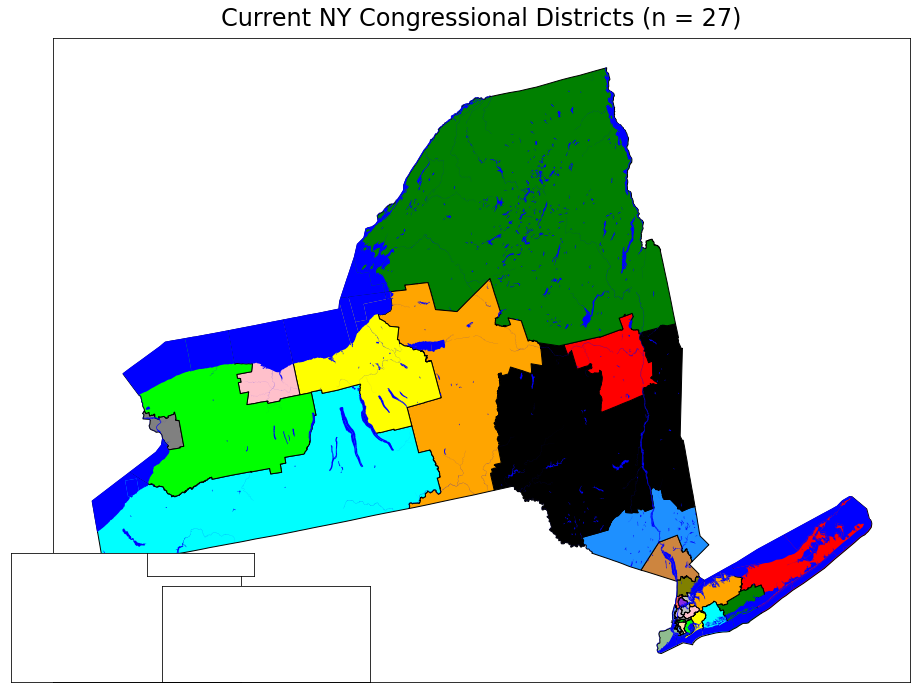

In [15]:
s = time.time()
# main_map_crs = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs "
# alaska_crs = "epsg:3338"
# hawaii_crs = "+proj=tmerc +lat_0=21.16666666666667 +lon_0=-158 +k=0.99999 +x_0=500000.0000000002 +y_0=0 +datum=NAD83 +units=us-ft +no_defs "


show_tracts = False
show_water = True

print('main map...')

print('\treprojecting...')

main_map_bounds = unary_union(state_gdf[state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).geometry.tolist()).bounds
main_map_aspect_ratio = (main_map_bounds[2] - main_map_bounds[0]) / (main_map_bounds[3] - main_map_bounds[1])

fig, ax = plt.subplots(1,1,figsize=(24, 24/main_map_aspect_ratio))
ax.set_aspect('equal')


print('\tplotting...')

for this_state in state_gdf[(state_gdf['STUSPS'].isin(these_states_dict.keys())) & (state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI']))]['STUSPS'].tolist():#.sort_values().tolist():
    print('\t\tPlotting {0:}...'.format(this_state))
    cdlist = cd_gdf[cd_gdf['STUSAB'] == this_state]['CD116'].drop_duplicates().sort_values().tolist()
    for i in range(1, len(cdlist)+1):
        cd_gdf[
            (cd_gdf['STUSAB'] == this_state) 
            & (cd_gdf['CD116'] == i)
        ].to_crs(main_map_crs).plot(ax=ax, color=district_color_cycle[i], edgecolor='black')
#         annotator = i
#         this_district_geo = unary_union(cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116'] == i)].to_crs(main_map_crs).geometry.tolist())
#         centerpoint = (this_district_geo.centroid.x, this_district_geo.centroid.y)
#         ax.annotate(annotator, centerpoint, 
#                     color='black', backgroundcolor='white', ha='center', va='center', fontsize=20)

if (show_tracts):
    print('\tplotting census tracts...')
    tract_gdf[tract_gdf['STATEFP'].apply(lambda x: x not in [2,15])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

if (show_water):
    print('\tplotting census tracts...')
    water_gdf[water_gdf['STUSAB'].apply(lambda x: x not in ['AK','HI'])].to_crs(main_map_crs).plot(ax=ax, color='blue', edgecolor='none', linewidth=0.5)



    
#ax.legend(handles=legend_list, fontsize=10)


if (len(list(these_states_dict.keys())) == 1):
    ax.set_title('Current {0:} Congressional Districts (n = {1:.0f})'.format(
        list(these_states_dict.keys())[0], 
        these_states_dict[list(these_states_dict.keys())[0]]['seats_old']
    ), fontsize=24, y=1.01)
else:
    ax.set_title('Current Congressional Districts', fontsize=24, y=1.01)

# # # # ax.tick_params(axis='both', labelsize=20)

# # # # # print('saving figure...')
# # # # # fig.savefig('{0:}{1:}_old.png'.format(script_dir, list(these_states_dict.keys())[0].lower()), format='png', dpi=300, bbox_inches='tight', facecolor='white')

# # # #plt.show()
# # e = time.time()
# # g += (e-s)
# # print('Done plotting in {0:.0f} minutes {1:.0f} seconds!'.format(np.floor((e-s)/60), (e-s)%60))
# # #[inset['axes_position'][0], inset['axes_position'][1], inset['axes_size'][0], inset['axes_size'][1]]

# # state_gdf[state_gdf['NAME'].apply(lambda x: x not in ['Alaska', 'Hawaii'])].to_crs(main_map_crs).plot(ax=ax)

print('AK inset...')
print('\treprojecting Alaska...')
ak_map_bounds = geopandas.GeoDataFrame(data=[[unary_union(county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAMELSAD'].apply(lambda x: 'aleutians west' not in x.lower()))].geometry.tolist())]], columns=['geometry'], crs=county_gdf.crs, geometry='geometry').to_crs(alaska_crs).bounds.values[0].tolist()
ak_map_aspect_ratio = (ak_map_bounds[2] - ak_map_bounds[0]) / (ak_map_bounds[3] - ak_map_bounds[1])

ak_inset_ax = ax.inset_axes([-0.049,0,ak_map_aspect_ratio*0.2,0.2])

#ak_inset_ax = ax.inset_axes([0,0,ak_map_aspect_ratio*1,1])

print('\t\treprojecting Aleutians West...')
aleutians_west_map_bounds = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Aleutians West')
].to_crs(alaska_crs).geometry.tolist()).bounds

aleutians_west_map_aspect_ratio = (aleutians_west_map_bounds[2] - aleutians_west_map_bounds[0]) / (aleutians_west_map_bounds[3] - aleutians_west_map_bounds[1])

# aleutians_inset_ax = ak_inset_ax.inset_axes([-0.325,-0.015,0.2*aleutians_west_map_aspect_ratio,0.2])   # to show Aletuians West in their actual geographic spot
aleutians_inset_ax = ak_inset_ax.inset_axes([0.59,0.825,0.175*aleutians_west_map_aspect_ratio,0.175])

print('plotting Alaska...')
cdlist = cd_gdf[cd_gdf['STUSAB'] == 'AK']['CD116'].drop_duplicates().sort_values().tolist()
for i in range(1, len(cdlist)+1):
    geopandas.overlay(
        cd_gdf[(cd_gdf['STUSAB'] == 'AK') & (cd_gdf['CD116'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=ak_inset_ax, color=district_color_cycle[i], edgecolor='black')
    geopandas.overlay(
        cd_gdf[(cd_gdf['STUSAB'] == 'AK') & (cd_gdf['CD116'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] == 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=aleutians_inset_ax, color=district_color_cycle[i], edgecolor='black')
# if (show_tracts):
#     print('\tplotting census tracts...')
#     tract_gdf[tract_gdf['STUSAB'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)
    

print('HI inset...')
print('\treprojecting and plotting Hawaii...')
print('\t\tremoving outer islands...')
honolulu_county_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Honolulu')
].geometry.tolist())
honolulu_county_bounds = honolulu_county_geo.bounds
fixed_honolulu_county_geo = unary_union(geopandas.overlay(
    geopandas.GeoDataFrame(data=[[honolulu_county_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'), 
    geopandas.GeoDataFrame(data=[[box(-160, honolulu_county_bounds[1], honolulu_county_bounds[2], honolulu_county_bounds[3])]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'),
    how='intersection'
).geometry.tolist())
other_hawaii_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] != 'Honolulu')
].geometry.tolist())
fixed_hawaii_geo = unary_union([other_hawaii_geo, fixed_honolulu_county_geo])
fixed_hawaii_gdf = geopandas.GeoDataFrame(data=[[fixed_hawaii_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry')

hi_map_bounds = fixed_hawaii_gdf.geometry.to_crs(hawaii_crs).geometry.apply(lambda x: x.bounds).values[0]
hi_map_aspect_ratio = (hi_map_bounds[2] - hi_map_bounds[0]) / (hi_map_bounds[3] - hi_map_bounds[1])

#print(hi_map_aspect_ratio)

hi_inset_ax = ax.inset_axes([0.128,0,hi_map_aspect_ratio*0.15,0.15])

print('plotting Hawaii...')
cdlist = cd_gdf[cd_gdf['STUSAB'] == 'HI']['CD116'].drop_duplicates().sort_values().tolist()
for i in range(1, len(cdlist)+1):
    geopandas.overlay(
        cd_gdf[(cd_gdf['STUSAB'] == 'HI') & (cd_gdf['CD116'] == i)], 
        fixed_hawaii_gdf,
        #county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(hawaii_crs).plot(ax=hi_inset_ax, color=district_color_cycle[i], edgecolor='black')

for thisax in [ax, ak_inset_ax, aleutians_inset_ax, hi_inset_ax]:
    thisax.set_xticks([])
    thisax.set_yticks([])

# print('saving figure...')
# fig.savefig(script_dir+'all-districts-orig.jpg', format='jpg', dpi=300, bbox_inches='tight')
#plt.show()
e = time.time()
g += (e-s)
print('Done plotting in {0:,.0f} seconds!'.format(e-s))

# How many districts in each state?

In [16]:
for this_state_name, this_state in these_states_dict.items():
    if (this_state['seats_new'] == 1):
        these_states_dict[this_state_name]['target'] = -1
    else:
        these_states_dict[this_state_name]['target'] = cd_gdf[cd_gdf['STUSAB'] == this_state_name]['POP100'].sum() / this_state['seats_new']
    
    
these_states_dict
#water_gdf.head(1).T

{'NY': {'STATEFP': 36,
  'seats_old': 27,
  'seats_new': 26,
  'target': 776971.1153846154}}

# NEW YORK

In [17]:
s = time.time()

this_state = 'NY'
examine_duplicates = True

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

#print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[ 

['Richmond County',11], 
    
['Rockland County',17],
    ['Putnam County',17],
    
['Monroe County',25],
    
['Albany County',20],
    ['Schenectady County',20],
    ['Rensselaer County',20],
     
['Dutchess County',18],

['Onondaga County',24],
    ['Oswego County',24],
    ['Madison County',24],
    ['Cortland County',24],
    ['Chenango County',24],    
    
['Orleans County',23],
    ['Genesee County',23],
    ['Wyoming County',23],
    ['Cattaraugus County',23], 
    ['Chautauqua County',23],
    
['Chemung County',22], 
    ['Steuben County',22], 
    ['Allegany County',22], 
    ['Schuyler County',22], 
    ['Tompkins County',22], 
    ['Yates County',22], 
    ['Seneca County',22], 
    ['Wayne County',22], 
    ['Cayuga County',22], 
    ['Tioga County',22],

['Delaware County',19], 
    ['Sullivan County',19], 
    ['Columbia County',19], 
    ['Greene County',19], 
    ['Otsego County',19], 
    ['Schoharie County',19], 
    ['Montgomery County',19], 
    ['Fulton County',19], 
    ['Herkimer County',19], 

], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
    
['North New Hyde Park',6],
    ['Garden City Park',6],
    ['Manhasset Hills',6],
    ['Herricks',6],
    

['Inwood',5],
    ['Cedarhurst',5],
    ['Lawrence',5],
    ['Atlantic Beach',5],
    ['East Atlantic Beach',5],
    

['Floral Park',4], 
    ['Elmont',4], 
    ['Franklin Square',4], 
    ['Hempstead',4], 
    ['West Hempstead',4], 
    ['South Hempstead',4], 
    ['Lakeview',4], 
    ['Rockville Centre',4],
    ['Valley Stream',4], 
    ['North Valley Stream',4], 
    ['South Valley Stream',4], 
    ['Malverne',4], 
    ['Lynbrook',4], 
    ['North Lynbrook',4],
    ['Oceanside',4],
    ['Long Beach',4],
    ['Garden City',4],
    ['New Hyde Park',4],
    ['Baldwin',4],
    ['Uniondale',4], 
    
        
['Holbrook',1], 
    ['Ronkonkoma',1], 
    ['Bohemia',1], 
    ['Sayville',1], 
    ['West Sayville',1], 
    ['Oakdale',1],
    

['Amityville',2], 
    ['East Massapequa',2],
    ['South Farmingdale',2], 
    

['Pelham',16], 
    ['Pelham Manor',16], 
    ['Mount Vernon',16], 
    ['New Rochelle',16], 
    ['Yonkers',16],
    ['Bronxville',16], 
    ['Eastchester',16], 
    ['Tuckahoe',16], 
    ['Larchmont',16], 
    ['Mamaroneck',16], 
    ['Rye',16],
    ['Scarsdale',16], 
    ['Hastings-on-Hudson',16],
    ['Harrison',16], 
    ['White Plains',16], 
    ['Rye Brook',16], 
    ['Port Chester',16],
    ['Greenville',16], 
    ['Dobbs Ferry',16], 
    ['Ardsley',16], 
    ['Hartsdale',16], 
    ['Irvington',16],
    

['Fort Montgomery',17], 
    ['Highland Falls',17], 
    ['West Point',17],
    ['Woodbury',17],
    
    
['Buffalo',26],
    ['Lackawanna',26],
    ['West Seneca',26], 
    ['Cheektowaga',26], 
    ['Depew',26],
    ['Kenmore',26],
    ['Eggertsville',26],
    ['Williamsville',26],
    ['Tonawanda',26],
    ['Tonawanda Town',26],
    ['North Tonawanda',26],


['Kingston',18],
    ['Highland',18],
    ['Marlboro',18],

    
['Endicott',22], 
    
['Utica',19],

], columns=['NAME', 'new_district_by_place'])


#print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']

print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf[place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]].reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('Accounting for known duplicate places...')
keepers = {}
keepers['Tuckahoe'] = {'GEOID': '1600000US3675583', 'description': 'overlaps 2 tracts containing 7,084 people'}
keepers['Greenville'] = {'GEOID': '1600000US3630642', 'description': 'overlaps 1 tracts containing 5,479 people'}
keepers['Woodbury'] = {'GEOID': '1600000US3682750', 'description': 'overlaps 2 tracts containing 11,526 people'}



for k,v in keepers.items():
    print('\t{0:}: Keeping GEOID = {1:}: {2:}!'.format(k, v['GEOID'], v['description']))
    place_mapper_gdf = place_mapper_gdf.drop(place_mapper_gdf[(place_mapper_gdf['NAME'] == k) & (place_mapper_gdf.index != v['GEOID'])].index, axis=0)

print('\n')
print('checking for additional duplicate names...')
duplicate_place_names = place_mapper_gdf[place_mapper_gdf['NAME'].duplicated()]['NAME'].tolist()
for this_place in duplicate_place_names:
    print('Examining {0:}...'.format(this_place))
    
    for ix, thisrow in place_gdf[
        (place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
        & (place_gdf['NAME'] == this_place)
    ].to_crs(equal_area_crs).iterrows():
        included_tracts = []
        place_area = thisrow.geometry.area
        print('\t{0:} (GEOID = {1:}), place area = {2:,.2f} km^2...'.format(thisrow['NAMELSAD'], ix, place_area / 1000000))
        
        for jx, thatrow in county_gdf[
            (county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
            & (county_gdf.to_crs(equal_area_crs).geometry.apply(lambda x: x.intersects(thisrow.geometry)))
        ].to_crs(equal_area_crs).iterrows():
            if (thatrow.geometry.intersection(thisrow.geometry).area >= absolute_overlap_tol):
                print('\t\t...overlaps with {0:} by {1:,.2f} km^2...'.format(thatrow['NAMELSAD'], thatrow.geometry.intersection(thisrow.geometry).area / 1000000))
                for kx, otherrow in tract_gdf[
                    #(tract_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
                    (tract_gdf['STUSAB'] == this_state)
                    & (tract_gdf['COUNTY_NAME'] == thatrow['NAMELSAD'])
                    & (tract_gdf.to_crs(equal_area_crs).geometry.apply(lambda x: x.intersects(thisrow.geometry)))
                ].to_crs(equal_area_crs).iterrows():
                    tract_area = otherrow.geometry.area
                    overlap_area = otherrow.geometry.intersection(thisrow.geometry).area
                    pct_overlap = overlap_area / tract_area
                    if (pct_overlap >= desired_pct_area_overlap):
                        print('\t\t\tOverlaps {0:.1%} of census tract {1:}...'.format(pct_overlap, otherrow['census_tract']))
                        included_tracts.append(kx)
        print('\t{0:} (GEOID = {1:}) overlaps {2:.0f} tracts containing {3:,.0f} people!'.format(thisrow['NAME'], ix, len(tract_gdf[tract_gdf.index.isin(included_tracts)]), tract_gdf[tract_gdf.index.isin(included_tracts)]['POP100'].sum()))
        print('-------------------------------------')
        print('\n')
        
print('\n')
for i in range(1, nDistricts+1):
    print('Looking for tracts related to places in District {0:.0f}...'.format(i))
    tracts_here = []
    this_district_places_geo = unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())
    tracts_within = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.within(this_district_places_geo))
    ].index.tolist()
    if (len(tracts_within) > 0):
        print('\tTracts within District {0:.0f}: {1:,.0f}...'.format(i, len(tracts_within)))
    tracts_here += tracts_within
    
    intersecting_tracts = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.intersects(this_district_places_geo))
        & ~(tract_gdf.index.isin(tracts_within))
    ].index.tolist()
    if (len(intersecting_tracts) > 0):
        print('\tTracts intersecting (but not within) District {0:.0f}: {1:,.0f}...'.format(i, len(intersecting_tracts)))
    
    cnt = 0
    for ix, thisrow in tract_gdf[tract_gdf.index.isin(intersecting_tracts)].iterrows():
        cnt += 1
        if (np.mod(cnt,50) == 1):            
            print('\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(intersecting_tracts)))
        tract_area_sq_deg = thisrow.geometry.area
        overlap_area_sq_deg = thisrow.geometry.intersection(this_district_places_geo).area
        overlap_pct = overlap_area_sq_deg / tract_area_sq_deg
        if (overlap_pct >= desired_pct_area_overlap):
            tracts_here.append(ix)
            #print('\t\t\tTract {0:}-{1:} overlaps by {2:.1%}...'.format(thisrow['COUNTY_NAME'].split(" County")[0], thisrow['census_tract'], overlap_pct))

    tract_gdf.loc[tracts_here, 'new_district'] = i

print('Assigning districts by tract number...')


# 10
tract_gdf.loc[['1400000US36061000201', '1400000US36061000202', '1400000US36061000500', '1400000US36061000600', '1400000US36061000700', '1400000US36061000800', '1400000US36061000900', '1400000US36061001001', '1400000US36061001002', '1400000US36061001200', '1400000US36061001300', '1400000US36061001401', '1400000US36061001402', '1400000US36061001501', '1400000US36061001502', '1400000US36061001600', '1400000US36061001800'], 'new_district'] = 10
tract_gdf.loc[['1400000US36061002000', '1400000US36061002100', '1400000US36061002201', '1400000US36061002202', '1400000US36061002400', '1400000US36061002500', '1400000US36061002601', '1400000US36061002602', '1400000US36061002700', '1400000US36061002800', '1400000US36061002901', '1400000US36061002902', '1400000US36061003001', '1400000US36061003002', '1400000US36061003100', '1400000US36061003200', '1400000US36061003300', '1400000US36061003400', '1400000US36061003601', '1400000US36061003602', '1400000US36061003700', '1400000US36061003800', '1400000US36061003900'], 'new_district'] = 10
tract_gdf.loc[['1400000US36061004001', '1400000US36061004002', '1400000US36061004100', '1400000US36061004200', '1400000US36061004300', '1400000US36061004400', '1400000US36061004500', '1400000US36061004700', '1400000US36061004800', '1400000US36061004900'], 'new_district'] = 10
tract_gdf.loc[['1400000US36061031703', '1400000US36061031704', '1400000US36061031900'], 'new_district'] = 10
tract_gdf.loc[['1400000US36061005501', '1400000US36061005502', '1400000US36061005700', '1400000US36061005900'], 'new_district'] = 10
tract_gdf.loc[['1400000US36061006100', '1400000US36061006300', '1400000US36061006500', '1400000US36061006700', '1400000US36061006900'], 'new_district'] = 10
tract_gdf.loc[['1400000US36061007100', '1400000US36061007300', '1400000US36061007500', '1400000US36061007700', '1400000US36061007900'], 'new_district'] = 10
tract_gdf.loc[['1400000US36061005000', '1400000US36061005200', '1400000US36061005400', '1400000US36061005600', '1400000US36061005800', '1400000US36061006000', '1400000US36061006200', '1400000US36061006400', '1400000US36061006600', '1400000US36061006800', '1400000US36061007001', '1400000US36061007002', '1400000US36061007200', '1400000US36061007400', '1400000US36061007600', '1400000US36061007800'], 'new_district'] = 10
tract_gdf.loc[['1400000US36061008100', '1400000US36061008300', '1400000US36061008700', '1400000US36061008900', '1400000US36061009100', '1400000US36061009300', '1400000US36061009500', '1400000US36061009700', '1400000US36061009901', '1400000US36061009902', '1400000US36061009903'], 'new_district'] = 10
tract_gdf.loc[['1400000US36061008000', '1400000US36061008200', '1400000US36061008400', '1400000US36061008601', '1400000US36061008602', '1400000US36061008603', '1400000US36061008800', '1400000US36061009000', '1400000US36061009200', '1400000US36061009200', '1400000US36061009400', '1400000US36061009600', '1400000US36061009800'], 'new_district'] = 10
tract_gdf.loc[['1400000US36061010100', '1400000US36061010300', '1400000US36061010900', '1400000US36061011100', '1400000US36061011300', '1400000US36061011500', '1400000US36061011700', '1400000US36061011900', '1400000US36061012101', '1400000US36061012102', '1400000US36061012500', '1400000US36061012700', '1400000US36061012901', '1400000US36061012902', '1400000US36061013100', '1400000US36061013300', '1400000US36061013501', '1400000US36061013502', '1400000US36061013700', '1400000US36061013900'], 'new_district'] = 10
tract_gdf.loc[['1400000US36061010000', '1400000US36061010200', '1400000US36061010400', '1400000US36061011201', '1400000US36061011202', '1400000US36061011203'], 'new_district'] = 10
tract_gdf.loc[['1400000US36061010601', '1400000US36061010801', '1400000US36061010802', '1400000US36061010803'], 'new_district'] = 10
tract_gdf.loc[['1400000US36061010602', '1400000US36061011000', '1400000US36061011401', '1400000US36061011402', '1400000US36061011600', '1400000US36061011800', '1400000US36061012000'], 'new_district'] = 10
tract_gdf.loc[['1400000US36061014500', '1400000US36061014700', '1400000US36061014900'], 'new_district'] = 10
tract_gdf.loc[['1400000US36061015101', '1400000US36061015102', '1400000US36061015301', '1400000US36061015302', '1400000US36061015501', '1400000US36061015502', '1400000US36061015900', '1400000US36061000100'], 'new_district'] = 10


# 12
tract_gdf.loc[['1400000US36061012400', '1400000US36061012601', '1400000US36061012602', '1400000US36061012800', '1400000US36061013000', '1400000US36061013201', '1400000US36061013202', '1400000US36061013203', '1400000US36061013400', '1400000US36061013601', '1400000US36061013602', '1400000US36061013603', '1400000US36061013604', '1400000US36061013800', '1400000US36061014000', '1400000US36061014200', '1400000US36061014300', '1400000US36061014401', '1400000US36061014402', '1400000US36061014601', '1400000US36061014602', '1400000US36061014801', '1400000US36061014802'], 'new_district'] = 12
tract_gdf.loc[['1400000US36061015001', '1400000US36061015002', '1400000US36061015200', '1400000US36061015401', '1400000US36061015402', '1400000US36061015403', '1400000US36061015601', '1400000US36061015602', '1400000US36061015700', '1400000US36061015801', '1400000US36061015802', '1400000US36061016001', '1400000US36061016002', '1400000US36061016100', '1400000US36061016200', '1400000US36061016300', '1400000US36061016400', '1400000US36061016500', '1400000US36061016600', '1400000US36061016700', '1400000US36061016800', '1400000US36061016900', '1400000US36061017000', '1400000US36061017100', '1400000US36061017200', '1400000US36061017300', '1400000US36061017401', '1400000US36061017402', '1400000US36061017500', '1400000US36061017700', '1400000US36061017800', '1400000US36061017900'], 'new_district'] = 12
tract_gdf.loc[['1400000US36061018000', '1400000US36061018100', '1400000US36061018200', '1400000US36061018300', '1400000US36061018400', '1400000US36061018500', '1400000US36061018600', '1400000US36061018700', '1400000US36061018800', '1400000US36061018900', '1400000US36061019000', '1400000US36061019100', '1400000US36061019200', '1400000US36061019300', '1400000US36061019400', '1400000US36061019500', '1400000US36061019600', '1400000US36061019701', '1400000US36061019702', '1400000US36061019800', '1400000US36061019900', '1400000US36061020000', '1400000US36061020101', '1400000US36061020102', '1400000US36061020300', '1400000US36061020500', '1400000US36061020600', '1400000US36061020701', '1400000US36061020800', '1400000US36061020901'], 'new_district'] = 12
tract_gdf.loc[['1400000US36061021000', '1400000US36061021100', '1400000US36061021200', '1400000US36061021303', '1400000US36061021400', '1400000US36061021500', '1400000US36061021600', '1400000US36061021703', '1400000US36061021800', '1400000US36061021900'], 'new_district'] = 12
tract_gdf.loc[['1400000US36061022000', '1400000US36061022102', '1400000US36061022200', '1400000US36061022301', '1400000US36061022302', '1400000US36061022400', '1400000US36061022500', '1400000US36061022600', '1400000US36061022700', '1400000US36061022800', '1400000US36061022900', '1400000US36061023000', '1400000US36061024000', '1400000US36061024200', '1400000US36061025700'], 'new_district'] = 12
tract_gdf.loc[['1400000US36061023100', '1400000US36061023200', '1400000US36061023300', '1400000US36061023400', '1400000US36061023501', '1400000US36061023502', '1400000US36061023600', '1400000US36061023700', '1400000US36061023802', '1400000US36061023803', '1400000US36061023804', '1400000US36061023900', '1400000US36061024100', '1400000US36061024301', '1400000US36061024302', '1400000US36061024500', '1400000US36061024700'], 'new_district'] = 12
tract_gdf.loc[['1400000US36061025900'], 'new_district'] = 12
tract_gdf.loc[['1400000US36061012200'], 'new_district'] = 12
tract_gdf.loc[['1400000US36081003700', '1400000US36081008100', '1400000US36081008300', '1400000US36081008700', '1400000US36081009100', '1400000US36081009900'], 'new_district'] = 12


# 15
tract_gdf.loc[['1400000US36005000100', '1400000US36005000200', '1400000US36005000400', '1400000US36005001901', '1400000US36005001902', '1400000US36005001903', '1400000US36005001904', '1400000US36005002001', '1400000US36005002002', '1400000US36005002300', '1400000US36005002400', '1400000US36005002500', '1400000US36005002701', '1400000US36005002702', '1400000US36005002800'], 'new_district'] = 15     # S Bronx
tract_gdf.loc[['1400000US36005003100', '1400000US36005003300', '1400000US36005003500', '1400000US36005003700', '1400000US36005003800', '1400000US36005003900', '1400000US36005004001', '1400000US36005004100', '1400000US36005004200', '1400000US36005004300', '1400000US36005004400', '1400000US36005004600', '1400000US36005004800', '1400000US36005005001', '1400000US36005005002', '1400000US36005005100', '1400000US36005005200', '1400000US36005005300', '1400000US36005005400', '1400000US36005005600', '1400000US36005005902', '1400000US36005006000', '1400000US36005006100', '1400000US36005006200', '1400000US36005006301', '1400000US36005006302', '1400000US36005006400', '1400000US36005006500', '1400000US36005006700', '1400000US36005006800', '1400000US36005006900'], 'new_district'] = 15     # S Bronx
tract_gdf.loc[['1400000US36005007000', '1400000US36005007100', '1400000US36005007200', '1400000US36005007300', '1400000US36005007400', '1400000US36005007500', '1400000US36005007600', '1400000US36005007700', '1400000US36005007800', '1400000US36005007900', '1400000US36005008300', '1400000US36005008500', '1400000US36005008600', '1400000US36005008700', '1400000US36005008900', '1400000US36005009200', '1400000US36005009301', '1400000US36005009302', '1400000US36005009600', '1400000US36005009800', '1400000US36005011502', '1400000US36005011701', '1400000US36005011702', '1400000US36005011900', '1400000US36005012101', '1400000US36005012102', '1400000US36005012300', '1400000US36005012500', '1400000US36005012701', '1400000US36005012901'], 'new_district'] = 15     # S Bronx
tract_gdf.loc[['1400000US36005013100', '1400000US36005013300', '1400000US36005013500', '1400000US36005014100', '1400000US36005014300', '1400000US36005014500', '1400000US36005014701', '1400000US36005014702', '1400000US36005014900', '1400000US36005015100', '1400000US36005015300', '1400000US36005015500', '1400000US36005015700', '1400000US36005015900'], 'new_district'] = 15     # S Bronx
tract_gdf.loc[['1400000US36005016100', '1400000US36005016300', '1400000US36005016500', '1400000US36005016700', '1400000US36005016900', '1400000US36005017100', '1400000US36005017300', '1400000US36005017500', '1400000US36005017701', '1400000US36005017702', '1400000US36005017901', '1400000US36005017902', '1400000US36005018101', '1400000US36005018102', '1400000US36005018301', '1400000US36005018302', '1400000US36005018501', '1400000US36005018502', '1400000US36005018900', '1400000US36005019300', '1400000US36005019500', '1400000US36005019700', '1400000US36005019900'], 'new_district'] = 15
tract_gdf.loc[['1400000US36005020100', '1400000US36005020200', '1400000US36005020400', '1400000US36005020501', '1400000US36005020502', '1400000US36005020601', '1400000US36005020900', '1400000US36005021001', '1400000US36005021002', '1400000US36005021100', '1400000US36005021200', '1400000US36005021301', '1400000US36005021302', '1400000US36005021501', '1400000US36005021502', '1400000US36005021601', '1400000US36005021602', '1400000US36005021700', '1400000US36005021800', '1400000US36005021900','1400000US36005022101', '1400000US36005022102', '1400000US36005022200','1400000US36005022300', '1400000US36005022500', '1400000US36005022701', '1400000US36005022702', '1400000US36005022703', '1400000US36005022901', '1400000US36005022902'], 'new_district'] = 15
tract_gdf.loc[['1400000US36005023100', '1400000US36005023301', '1400000US36005023302'], 'new_district'] = 15
tract_gdf.loc[['1400000US36005024300'], 'new_district'] = 15
tract_gdf.loc[['1400000US36005036502', '1400000US36005036700', '1400000US36005036901', '1400000US36005036902'], 'new_district'] = 15
tract_gdf.loc[['1400000US36005001600', '1400000US36005008400', '1400000US36005009000'], 'new_district'] = 15
tract_gdf.loc[['1400000US36005038100', '1400000US36005039500', '1400000US36005037100', '1400000US36005037300', '1400000US36005037504', '1400000US36005037900'], 'new_district'] = 15
tract_gdf.loc[['1400000US36005036300', '1400000US36005036501'], 'new_district'] = 15
tract_gdf.loc[['1400000US36005011000', '1400000US36005011800', '1400000US36005013200', '1400000US36005013800', '1400000US36005013000', '1400000US36005018400', '1400000US36005019400'], 'new_district'] = 15     # E Bronx
tract_gdf.loc[['1400000US36005014400', '1400000US36005015200', '1400000US36005015800', '1400000US36005016000', '1400000US36005016200', '1400000US36005016400', '1400000US36005016600'], 'new_district'] = 15     # E Bronx
tract_gdf.loc[['1400000US36005023501', '1400000US36005023502'], 'new_district'] = 15
tract_gdf.loc[['1400000US36005024501', '1400000US36005024502', '1400000US36005035900'], 'new_district'] = 15


# 13
tract_gdf.loc[['1400000US36061025500', '1400000US36061026100', '1400000US36061026300', '1400000US36061026500', '1400000US36061026700', '1400000US36061026900', '1400000US36061027100', '1400000US36061027300', '1400000US36061027500', '1400000US36061027700', '1400000US36061027900', '1400000US36061028100', '1400000US36061028300', '1400000US36061028500', '1400000US36061028700', '1400000US36061029100', '1400000US36061029300', '1400000US36061029500', '1400000US36061029700', '1400000US36061029900', '1400000US36061030300', '1400000US36061030700', '1400000US36061030900'], 'new_district'] = 13     # Far N Manhattan
tract_gdf.loc[['1400000US36005028300', '1400000US36005028500', '1400000US36005028700', '1400000US36005028900', '1400000US36005029301', '1400000US36005029302', '1400000US36005029500','1400000US36005029700', '1400000US36005030100'], 'new_district'] = 13     # N Bronx
tract_gdf.loc[['1400000US36005030701', '1400000US36005030900', '1400000US36005032300', '1400000US36005033500', '1400000US36005035100'], 'new_district'] = 13     # N Bronx
tract_gdf.loc[['1400000US36005020000', '1400000US36005022000', '1400000US36005022401', '1400000US36005022403', '1400000US36005022404', '1400000US36005022800', '1400000US36005023000', '1400000US36005023200', '1400000US36005023600', '1400000US36005023702', '1400000US36005023703', '1400000US36005023800', '1400000US36005024000', '1400000US36005024400', '1400000US36005024600', '1400000US36005024800', '1400000US36005025000', '1400000US36005025200', '1400000US36005025400', '1400000US36005025600'], 'new_district'] = 13     # NE Bronx
tract_gdf.loc[['1400000US36005026100', '1400000US36005026300', '1400000US36005026500', '1400000US36005026701', '1400000US36005026702', '1400000US36005026900', '1400000US36005027300', '1400000US36005027700', '1400000US36005027900', '1400000US36005028100', '1400000US36005028400', '1400000US36005028600', '1400000US36005028800', '1400000US36005029600', '1400000US36005031000', '1400000US36005031200', '1400000US36005031400', '1400000US36005031600', '1400000US36005031800', '1400000US36005032400', '1400000US36005032600', '1400000US36005032800', '1400000US36005033000', '1400000US36005033201', '1400000US36005033202', '1400000US36005033400', '1400000US36005033601', '1400000US36005033602', '1400000US36005033801', '1400000US36005033802', '1400000US36005034000', '1400000US36005034200', '1400000US36005034400', '1400000US36005034800'], 'new_district'] = 13     # NE Bronx
tract_gdf.loc[['1400000US36005035000', '1400000US36005035600', '1400000US36005035800', '1400000US36005036000', '1400000US36005036400', '1400000US36005036800', '1400000US36005037000', '1400000US36005037200', '1400000US36005037400', '1400000US36005037600', '1400000US36005037800', '1400000US36005038000', '1400000US36005038200', '1400000US36005038301', '1400000US36005038303', '1400000US36005038304', '1400000US36005038500', '1400000US36005038600', '1400000US36005038700', '1400000US36005038800', '1400000US36005038900', '1400000US36005039000', '1400000US36005039100', '1400000US36005039200', '1400000US36005039300', '1400000US36005039400', '1400000US36005039600', '1400000US36005039700', '1400000US36005039800', '1400000US36005039901', '1400000US36005039902'], 'new_district'] = 13     # NE Bronx
tract_gdf.loc[['1400000US36005040100', '1400000US36005040302', '1400000US36005040303', '1400000US36005040304', '1400000US36005040400', '1400000US36005040501', '1400000US36005040502', '1400000US36005040600', '1400000US36005040701', '1400000US36005040702', '1400000US36005040800', '1400000US36005040900', '1400000US36005041100', '1400000US36005041300', '1400000US36005041500', '1400000US36005041900'], 'new_district'] = 13     # NE Bronx
tract_gdf.loc[['1400000US36005042000', '1400000US36005042100', '1400000US36005042200', '1400000US36005042300', '1400000US36005042400', '1400000US36005042500', '1400000US36005042901', '1400000US36005042902', '1400000US36005043501'], 'new_district'] = 13     # NE Bronx
tract_gdf.loc[['1400000US36005045800', '1400000US36005046000', '1400000US36005046203', '1400000US36005046204', '1400000US36005046205', '1400000US36005046206', '1400000US36005046207', '1400000US36005046208', '1400000US36005046209', '1400000US36005048401', '1400000US36005048402'], 'new_district'] = 13     # NE Bronx
tract_gdf.loc[['1400000US36005036100'], 'new_district'] = 13     # Far NE Bronx
tract_gdf.loc[['1400000US36005027600', '1400000US36005030000', '1400000US36005030201', '1400000US36005030202', '1400000US36005026601', '1400000US36005027402'], 'new_district'] = 13     # NE Bronx
tract_gdf.loc[['1400000US36061025300', '1400000US36061031100', '1400000US36061025100', '1400000US36061024900'], 'new_district'] = 13
tract_gdf.loc[['1400000US36005026400', '1400000US36005026602', '1400000US36005027401'], 'new_district'] = 13     # Far E Bronx
tract_gdf.loc[['1400000US36005024700', '1400000US36005024900', '1400000US36005025100'], 'new_district'] = 13
tract_gdf.loc[['1400000US36005024100'], 'new_district'] = 13
tract_gdf.loc[['1400000US36005023704', '1400000US36005023900'], 'new_district'] = 13
tract_gdf.loc[['1400000US36005025300', '1400000US36005025500', '1400000US36005025700'], 'new_district'] = 13


# 11
tract_gdf.loc[['1400000US36047005000', '1400000US36047005201', '1400000US36047005202', '1400000US36047005301', '1400000US36047005302', '1400000US36047005303', '1400000US36047005400', '1400000US36047000200', '1400000US36047001801', '1400000US36047001802', '1400000US36047001803', '1400000US36047001804', '1400000US36047002000', '1400000US36047007000'], 'new_district'] = 11    # SE Brooklyn
tract_gdf.loc[['1400000US36047002200', '1400000US36047006800',  '1400000US36047008500'], 'new_district'] = 11    # SE Brooklyn
tract_gdf.loc[['1400000US36047003000', '1400000US36047003400', '1400000US36047003600', '1400000US36047003800', '1400000US36047004400', '1400000US36047004600', '1400000US36047005601', '1400000US36047005602', '1400000US36047005800', '1400000US36047005900', '1400000US36047006000', '1400000US36047006200', '1400000US36047006400', '1400000US36047006600'], 'new_district'] = 11    # SE Brooklyn
tract_gdf.loc[['1400000US36047012600', '1400000US36047013000', '1400000US36047013400', '1400000US36047013800', '1400000US36047014000', '1400000US36047014200', '1400000US36047016000', '1400000US36047016200'], 'new_district'] = 11
tract_gdf.loc[['1400000US36047013600', '1400000US36047015200', '1400000US36047015400', '1400000US36047016400'], 'new_district'] = 11
tract_gdf.loc[['1400000US36047016800', '1400000US36047017400', '1400000US36047027800', '1400000US36047028000', '1400000US36047028600', '1400000US36047029200', '1400000US36047029400', '1400000US36047030400', '1400000US36047031401', '1400000US36047031402'], 'new_district'] = 11     # SE Brooklyn
tract_gdf.loc[['1400000US36047017000', '1400000US36047017200', '1400000US36047017600', '1400000US36047017800', '1400000US36047018000', '1400000US36047028200'], 'new_district'] = 11
tract_gdf.loc[['1400000US36047990100'], 'new_district'] = 11
tract_gdf.loc[['1400000US36047028400', '1400000US36047028800', '1400000US36047029000', '1400000US36047029600', '1400000US36047030000', '1400000US36047030200'], 'new_district'] = 11     # S Coast of Brooklyn
tract_gdf.loc[['1400000US36047030600', '1400000US36047030800', '1400000US36047032600', '1400000US36047032800', '1400000US36047033000', '1400000US36047033600', '1400000US36047034000', '1400000US36047034200', '1400000US36047034800', '1400000US36047035000', '1400000US36047035200', '1400000US36047035400', '1400000US36047035601', '1400000US36047035602'], 'new_district'] = 11     # S Coast of Brooklyn
tract_gdf.loc[['1400000US36047036001', '1400000US36047036002', '1400000US36047036200', '1400000US36047036400', '1400000US36047036600', '1400000US36047037000', '1400000US36047037401', '1400000US36047037402'], 'new_district'] = 11     # S Coast of Brooklyn
tract_gdf.loc[['1400000US36047038200'], 'new_district'] = 11


# 7
tract_gdf.loc[['1400000US36047007200', '1400000US36047007400', '1400000US36047007600', '1400000US36047007800', '1400000US36047008000', '1400000US36047008200', '1400000US36047008400', '1400000US36047008600', '1400000US36047008800', '1400000US36047009001', '1400000US36047009002', '1400000US36047009201', '1400000US36047009202', '1400000US36047009401', '1400000US36047009402', '1400000US36047009600', '1400000US36047009800'], 'new_district'] = 7     # SE inland part of Brooklyn
tract_gdf.loc[['1400000US36047010000', '1400000US36047010100', '1400000US36047010200', '1400000US36047010401', '1400000US36047010402', '1400000US36047010601', '1400000US36047010602', '1400000US36047010801', '1400000US36047010802', '1400000US36047011000', '1400000US36047011200', '1400000US36047011400', '1400000US36047011600', '1400000US36047011800'], 'new_district'] = 7     # SE inland part of Brooklyn
tract_gdf.loc[['1400000US36047012000', '1400000US36047012200', '1400000US36047012801', '1400000US36047013200', '1400000US36047014300', '1400000US36047014500', '1400000US36047014700', '1400000US36047014800', '1400000US36047015000', '1400000US36047017500','1400000US36047150200','1400000US36047016600', '1400000US36047018200', '1400000US36047018400', '1400000US36047018600', '1400000US36047018800', '1400000US36047019000', '1400000US36047019200', '1400000US36047019400', '1400000US36047019600', '1400000US36047019800'], 'new_district'] = 7     # SE inland part of Brooklyn
tract_gdf.loc[['1400000US36047020000', '1400000US36047020200', '1400000US36047020400', '1400000US36047020600', '1400000US36047020800', '1400000US36047021000', '1400000US36047021200', '1400000US36047021400', '1400000US36047021600', '1400000US36047021800', '1400000US36047022000', '1400000US36047022200', '1400000US36047022400', '1400000US36047022600', '1400000US36047022800', '1400000US36047023000', '1400000US36047023200', '1400000US36047023400', '1400000US36047023600', '1400000US36047023800', '1400000US36047024000', '1400000US36047024200', '1400000US36047024400', '1400000US36047024600', '1400000US36047024800'], 'new_district'] = 7     # SE inland part of Brooklyn
tract_gdf.loc[['1400000US36047025000', '1400000US36047025200', '1400000US36047025400', '1400000US36047025600', '1400000US36047025800', '1400000US36047026000', '1400000US36047026200', '1400000US36047026400', '1400000US36047026600', '1400000US36047026800', '1400000US36047027000', '1400000US36047027200', '1400000US36047027400', '1400000US36047027600', '1400000US36047029800', '1400000US36047038600', '1400000US36047038800', '1400000US36047039000', '1400000US36047039200', '1400000US36047039400', '1400000US36047039600', '1400000US36047039800'], 'new_district'] = 7     # SE inland part of Brooklyn
tract_gdf.loc[['1400000US36047040000', '1400000US36047040200', '1400000US36047040400', '1400000US36047040600', '1400000US36047040800', '1400000US36047041000', '1400000US36047041200', '1400000US36047041401', '1400000US36047041402', '1400000US36047041600', '1400000US36047041800', '1400000US36047042000', '1400000US36047042200', '1400000US36047042400', '1400000US36047042600', '1400000US36047042800', '1400000US36047043000', '1400000US36047043200', '1400000US36047043400', '1400000US36047043600', '1400000US36047043800', '1400000US36047044000', '1400000US36047044200', '1400000US36047044400', '1400000US36047044600', '1400000US36047044800'], 'new_district'] = 7     # SE inland part of Brooklyn
tract_gdf.loc[['1400000US36047045000', '1400000US36047045200', '1400000US36047045400', '1400000US36047045600', '1400000US36047045800', '1400000US36047046201', '1400000US36047046202', '1400000US36047046400', '1400000US36047046800', '1400000US36047047000', '1400000US36047047200', '1400000US36047047400', '1400000US36047047600', '1400000US36047047800', '1400000US36047048000', '1400000US36047048200', '1400000US36047048400', '1400000US36047048600', '1400000US36047048800'], 'new_district'] = 7     # SE inland part of Brooklyn
tract_gdf.loc[['1400000US36047049000', '1400000US36047049200', '1400000US36047049400', '1400000US36047049600', '1400000US36047049800',  '1400000US36047050001', '1400000US36047050002', '1400000US36047050202', '1400000US36047050401', '1400000US36047050402'], 'new_district'] = 7     # SE inland part of Brooklyn
tract_gdf.loc[['1400000US36047000100', '1400000US36047000301', '1400000US36047000501', '1400000US36047000502', '1400000US36047000700', '1400000US36047000900', '1400000US36047001100', '1400000US36047001300', '1400000US36047001501', '1400000US36047001502', '1400000US36047002100', '1400000US36047002300'], 'new_district'] = 7     # SE inland part of Brooklyn
tract_gdf.loc[['1400000US36047002901', '1400000US36047003101', '1400000US36047003102', '1400000US36047003300', '1400000US36047003500', '1400000US36047003700', '1400000US36047003900', '1400000US36047004100', '1400000US36047004300', '1400000US36047004500', '1400000US36047004700', '1400000US36047004900', '1400000US36047005100', '1400000US36047006300', '1400000US36047006500', '1400000US36047006700', '1400000US36047006901', '1400000US36047006902'], 'new_district'] = 7     # SE inland part of Brooklyn
tract_gdf.loc[['1400000US36047007100', '1400000US36047007500', '1400000US36047007700', '1400000US36047011700', '1400000US36047011901', '1400000US36047011902', '1400000US36047012100', '1400000US36047012700', '1400000US36047012901', '1400000US36047012902', '1400000US36047013100', '1400000US36047013300', '1400000US36047013500', '1400000US36047013700', '1400000US36047013900', '1400000US36047014101', '1400000US36047014102', '1400000US36047014901', '1400000US36047014902'], 'new_district'] = 7     # SE inland part of Brooklyn
tract_gdf.loc[['1400000US36047015100', '1400000US36047015300', '1400000US36047015500', '1400000US36047015700', '1400000US36047015900', '1400000US36047016100', '1400000US36047016300', '1400000US36047016500', '1400000US36047016700', '1400000US36047016900', '1400000US36047017100', '1400000US36047017700', '1400000US36047017900', '1400000US36047018100', '1400000US36047018300', '1400000US36047018501', '1400000US36047018700'], 'new_district'] = 7     # SE inland part of Brooklyn
tract_gdf.loc[['1400000US36047020500', '1400000US36047020700', '1400000US36047021500'], 'new_district'] = 7     # SE Brooklyn


# 9
tract_gdf.loc[['1400000US36047046000', '1400000US36047050600', '1400000US36047050801', '1400000US36047050803', '1400000US36047050804', '1400000US36047051001', '1400000US36047051002', '1400000US36047051200', '1400000US36047051400', '1400000US36047051601', '1400000US36047051602', '1400000US36047051800', '1400000US36047052000', '1400000US36047052600', '1400000US36047052800', '1400000US36047053000', '1400000US36047053200', '1400000US36047053400', '1400000US36047053800', '1400000US36047054200', '1400000US36047054400', '1400000US36047054600', '1400000US36047054800', '1400000US36047055000', '1400000US36047055200', '1400000US36047055400', '1400000US36047055600', '1400000US36047055800'], 'new_district'] = 9       # Flatbush
tract_gdf.loc[['1400000US36047056000', '1400000US36047056200', '1400000US36047056400', '1400000US36047056600', '1400000US36047056800', '1400000US36047057000', '1400000US36047057200', '1400000US36047057400', '1400000US36047057600', '1400000US36047057800', '1400000US36047058000','1400000US36047058200', '1400000US36047058400', '1400000US36047058600', '1400000US36047058800', '1400000US36047059000', '1400000US36047059200', '1400000US36047059402', '1400000US36047059403', '1400000US36047059404', '1400000US36047059600', '1400000US36047059800'], 'new_district'] = 9       # Flatbush
tract_gdf.loc[['1400000US36047060000', '1400000US36047060600', '1400000US36047060800', '1400000US36047061002', '1400000US36047061003', '1400000US36047061004', '1400000US36047061200', '1400000US36047061600', '1400000US36047062000', '1400000US36047062200', '1400000US36047062600', '1400000US36047062800', '1400000US36047063200', '1400000US36047063600', '1400000US36047063800', '1400000US36047064000', '1400000US36047064200', '1400000US36047064400', '1400000US36047064600', '1400000US36047064800', '1400000US36047065000', '1400000US36047065200', '1400000US36047065400', '1400000US36047065600', '1400000US36047065800', '1400000US36047066000', '1400000US36047066200', '1400000US36047066600', '1400000US36047067000', '1400000US36047067200', '1400000US36047067400', '1400000US36047067600', '1400000US36047067800'], 'new_district'] = 9       # Flatbush
tract_gdf.loc[['1400000US36047068000', '1400000US36047068200', '1400000US36047068600', '1400000US36047068800', '1400000US36047069000', '1400000US36047069200', '1400000US36047069601', '1400000US36047069602', '1400000US36047069800', '1400000US36047070000', '1400000US36047070201', '1400000US36047070202', '1400000US36047070203', '1400000US36047070601', '1400000US36047070602', '1400000US36047072000', '1400000US36047072200', '1400000US36047072400', '1400000US36047072600', '1400000US36047072800', '1400000US36047073000', '1400000US36047073200', '1400000US36047073400', '1400000US36047073600', '1400000US36047073800', '1400000US36047074000', '1400000US36047074200', '1400000US36047074400', '1400000US36047074600', '1400000US36047074800', '1400000US36047075000', '1400000US36047075200', '1400000US36047075400', '1400000US36047075600', '1400000US36047075800', '1400000US36047076000', '1400000US36047076200', '1400000US36047076400', '1400000US36047076600', '1400000US36047076800', '1400000US36047077000', '1400000US36047077200', '1400000US36047077400', '1400000US36047077600'], 'new_district'] = 9       # Flatbush
tract_gdf.loc[['1400000US36047078000', '1400000US36047078200', '1400000US36047078400', '1400000US36047078601', '1400000US36047078602', '1400000US36047078801', '1400000US36047078802', '1400000US36047079001', '1400000US36047079002', '1400000US36047079201', '1400000US36047079202', '1400000US36047079400', '1400000US36047079602', '1400000US36047081600', '1400000US36047081800', '1400000US36047082000', '1400000US36047082200', '1400000US36047082400', '1400000US36047082600', '1400000US36047082800', '1400000US36047083000', '1400000US36047083200', '1400000US36047083400', '1400000US36047083600', '1400000US36047083800', '1400000US36047084000', '1400000US36047084600', '1400000US36047084800', '1400000US36047085000', '1400000US36047085200', '1400000US36047085400', '1400000US36047085600', '1400000US36047085800'], 'new_district'] = 9       # Flatbush
tract_gdf.loc[['1400000US36047086000', '1400000US36047086200', '1400000US36047093200', '1400000US36047093400', '1400000US36047093600', '1400000US36047094401', '1400000US36047094402', '1400000US36047094600', '1400000US36047095000', '1400000US36047095400', '1400000US36047095600', '1400000US36047095800', '1400000US36047096000', '1400000US36047096200', '1400000US36047096400', '1400000US36047096600', '1400000US36047096800', '1400000US36047097000', '1400000US36047097400', '1400000US36047098600', '1400000US36047098800'], 'new_district'] = 9       # Flatbush
tract_gdf.loc[['1400000US36047099000', '1400000US36047099200', '1400000US36047099400', '1400000US36047099600', '1400000US36047099800', '1400000US36047100400', '1400000US36047100600', '1400000US36047100800', '1400000US36047101000', '1400000US36047101200', '1400000US36047101400', '1400000US36047101600', '1400000US36047101800', '1400000US36047102000', '1400000US36047102200', '1400000US36047102400', '1400000US36047102600', '1400000US36047102801', '1400000US36047102802', '1400000US36047103401', '1400000US36047103402', '1400000US36047105804', '1400000US36047107002', '1400000US36047152200'], 'new_district'] = 9       # Flatbush
tract_gdf.loc[['1400000US36047021300', '1400000US36047031900', '1400000US36047032100', '1400000US36047032300', '1400000US36047032500', '1400000US36047032700', '1400000US36047032900', '1400000US36047033100', '1400000US36047079601', '1400000US36047079801', '1400000US36047079802'], 'new_district'] = 9       # Flatbush
tract_gdf.loc[['1400000US36047080000', '1400000US36047080200', '1400000US36047080400', '1400000US36047080600', '1400000US36047080800', '1400000US36047081000', '1400000US36047081400', '1400000US36047086400', '1400000US36047086600', '1400000US36047086800', '1400000US36047087000', '1400000US36047087200', '1400000US36047087401', '1400000US36047087600', '1400000US36047087800', '1400000US36047088001', '1400000US36047088002', '1400000US36047088200', '1400000US36047088400', '1400000US36047088600', '1400000US36047088800', '1400000US36047089000', '1400000US36047089400', '1400000US36047089600', '1400000US36047091600', '1400000US36047092000', '1400000US36047092200', '1400000US36047092800', '1400000US36047093000', '1400000US36047093800', '1400000US36047098200', '1400000US36047098400', '1400000US36047105801', '1400000US36047107001', '1400000US36047107003', '1400000US36047109800',  '1400000US36047089200'], 'new_district'] = 9       # Flatbush


# 8
tract_gdf.loc[['1400000US36047019300', '1400000US36047019500', '1400000US36047019700', '1400000US36047019900', '1400000US36047020100', '1400000US36047020300', '1400000US36047021700', '1400000US36047021900', '1400000US36047022100', '1400000US36047022700', '1400000US36047022900', '1400000US36047023100', '1400000US36047023300', '1400000US36047023500', '1400000US36047024100', '1400000US36047024300', '1400000US36047024500', '1400000US36047024700', '1400000US36047024900', '1400000US36047025100', '1400000US36047025300', '1400000US36047025500', '1400000US36047025700', '1400000US36047025901', '1400000US36047025902', '1400000US36047026100', '1400000US36047026300', '1400000US36047026500', '1400000US36047026700', '1400000US36047026900'], 'new_district'] = 8       # E Brooklyn
tract_gdf.loc[['1400000US36047027100', '1400000US36047027300', '1400000US36047027500', '1400000US36047027700', '1400000US36047027900', '1400000US36047028100', '1400000US36047028300', '1400000US36047028501', '1400000US36047028502', '1400000US36047028700', '1400000US36047028900', '1400000US36047029100', '1400000US36047029300', '1400000US36047029500', '1400000US36047029700', '1400000US36047029900', '1400000US36047030100', '1400000US36047030300', '1400000US36047030500', '1400000US36047030700', '1400000US36047030900', '1400000US36047031100', '1400000US36047031300', '1400000US36047031500', '1400000US36047031701', '1400000US36047031702', '1400000US36047033300', '1400000US36047033500', '1400000US36047033701', '1400000US36047033702', '1400000US36047033900'], 'new_district'] = 8       # E Brooklyn
tract_gdf.loc[['1400000US36047034100', '1400000US36047034300', '1400000US36047034500', '1400000US36047034700', '1400000US36047034901', '1400000US36047034902', '1400000US36047035101', '1400000US36047035102', '1400000US36047035301', '1400000US36047035302', '1400000US36047035500', '1400000US36047035701', '1400000US36047035702', '1400000US36047035900', '1400000US36047036100', '1400000US36047036300', '1400000US36047036501', '1400000US36047036502', '1400000US36047036700', '1400000US36047036900', '1400000US36047037100', '1400000US36047037300', '1400000US36047037500', '1400000US36047037700', '1400000US36047037900', '1400000US36047038100', '1400000US36047038300', '1400000US36047038500', '1400000US36047038700', '1400000US36047038900', '1400000US36047039100', '1400000US36047039300', '1400000US36047039500', '1400000US36047039700', '1400000US36047039900'], 'new_district'] = 8       # E Brooklyn
tract_gdf.loc[['1400000US36047040100', '1400000US36047040300', '1400000US36047040500', '1400000US36047040700', '1400000US36047040900', '1400000US36047041100', '1400000US36047041300', '1400000US36047041500', '1400000US36047041700', '1400000US36047041900', '1400000US36047042100', '1400000US36047042300', '1400000US36047042500', '1400000US36047042700', '1400000US36047042900', '1400000US36047043100', '1400000US36047043300', '1400000US36047043500', '1400000US36047043700',	'1400000US36047043900', '1400000US36047044100', '1400000US36047044300', '1400000US36047044500', '1400000US36047044700', '1400000US36047044901', '1400000US36047047700', '1400000US36047048100', '1400000US36047048500', '1400000US36047048900', '1400000US36047049100', '1400000US36047049301', '1400000US36047049302', '1400000US36047049500', '1400000US36047049700'], 'new_district'] = 8       # E Brooklyn
tract_gdf.loc[['1400000US36047050100', '1400000US36047050300', '1400000US36047050500', '1400000US36047050700', '1400000US36047050900', '1400000US36047051100', '1400000US36047051300', '1400000US36047052700', '1400000US36047052900', '1400000US36047089800', '1400000US36047090000', '1400000US36047090200', '1400000US36047090600', '1400000US36047090800', '1400000US36047091000', '1400000US36047091200', '1400000US36047091800', '1400000US36047092400', '1400000US36047107800'], 'new_district'] = 8       # E Brooklyn
tract_gdf.loc[['1400000US36047110400', '1400000US36047110600', '1400000US36047111000', '1400000US36047111600', '1400000US36047111800', '1400000US36047112000', '1400000US36047112200', '1400000US36047112400', '1400000US36047112600', '1400000US36047112800', '1400000US36047113000', '1400000US36047113200', '1400000US36047113400', '1400000US36047114201', '1400000US36047114202', '1400000US36047114400', '1400000US36047114600', '1400000US36047115000', '1400000US36047115200', '1400000US36047115600', '1400000US36047115800', '1400000US36047116000', '1400000US36047116200', '1400000US36047116400', '1400000US36047116600', '1400000US36047116800'], 'new_district'] = 8       # E Brooklyn
tract_gdf.loc[['1400000US36047117000', '1400000US36047117201', '1400000US36047117202', '1400000US36047117400', '1400000US36047117601', '1400000US36047117602', '1400000US36047117800', '1400000US36047118000', '1400000US36047118201', '1400000US36047118202', '1400000US36047118400', '1400000US36047118600', '1400000US36047118800', '1400000US36047119000', '1400000US36047119200', '1400000US36047119400', '1400000US36047119600', '1400000US36047119800', '1400000US36047120000', '1400000US36047120200', '1400000US36047120801', '1400000US36047120802', '1400000US36047120803', '1400000US36047121000', '1400000US36047121400', '1400000US36047122000', '1400000US36047123700', ], 'new_district'] = 8       # E Brooklyn
tract_gdf.loc[['1400000US36047053101', '1400000US36047053102'], 'new_district'] = 8       # E Brooklyn


# 14
tract_gdf.loc[['1400000US36047019100', '1400000US36047021100', '1400000US36047049900', '1400000US36047051500', '1400000US36047051700', '1400000US36047051900', '1400000US36047052300', '1400000US36047052500', '1400000US36047053300', '1400000US36047053500', '1400000US36047053700', '1400000US36047053900'], 'new_district'] = 14     # Williamsburg (Brooklyn)
tract_gdf.loc[['1400000US36047054300', '1400000US36047054500', '1400000US36047054700', '1400000US36047054900', '1400000US36047055100', '1400000US36047055300', '1400000US36047055500', '1400000US36047055700', '1400000US36047056100', '1400000US36047056301', '1400000US36047056302', '1400000US36047056500', '1400000US36047056900', '1400000US36047057100', '1400000US36047057300', '1400000US36047057500', '1400000US36047057901', '1400000US36047057902', '1400000US36047058901', '1400000US36047058902', '1400000US36047059100', '1400000US36047059300', '1400000US36047044902', '1400000US36047045300', ], 'new_district'] = 14     # Williamsburg (Brooklyn)
tract_gdf.loc[['1400000US36081010701', '1400000US36081033100', '1400000US36081099100', '1400000US36081099705', '1400000US36081099900'], 'new_district'] = 14     # Far N Queens
tract_gdf.loc[['1400000US36081088902', '1400000US36081088903', '1400000US36081090700', '1400000US36081091900', '1400000US36081092500', '1400000US36081092900', '1400000US36081093900', '1400000US36081094500', '1400000US36081094700'], 'new_district'] = 14     # NNE Queens
tract_gdf.loc[['1400000US36081097300', '1400000US36081098100', '1400000US36081098700', '1400000US36081099701', '1400000US36081099703', '1400000US36081099704'], 'new_district'] = 14     # NNE Queens
tract_gdf.loc[['1400000US36081101700', '1400000US36081102900', '1400000US36081103300', '1400000US36081103900', '1400000US36081104700', '1400000US36081105900', '1400000US36081108500', '1400000US36081109300', '1400000US36081109700', '1400000US36081109900'], 'new_district'] = 14     # NNE Queens (south of above)
tract_gdf.loc[['1400000US36081000101', '1400000US36081000102', '1400000US36081000103', '1400000US36081000104', '1400000US36081000701', '1400000US36081000702', '1400000US36081001901', '1400000US36081001902', '1400000US36081001903', '1400000US36081002500', '1400000US36081003100', '1400000US36081003301', '1400000US36081003302', '1400000US36081003900', '1400000US36081004300', '1400000US36081004500', '1400000US36081004700', '1400000US36081005100', '1400000US36081005300', '1400000US36081005500', '1400000US36081005700', '1400000US36081005900', '1400000US36081006100',  '1400000US36081006300', '1400000US36081006501', '1400000US36081006502', '1400000US36081006900', '1400000US36081007100', '1400000US36081007300', '1400000US36081007500', '1400000US36081007700', '1400000US36081007900', '1400000US36081008500', '1400000US36081009500', '1400000US36081009700'], 'new_district'] = 14      # W Queens
tract_gdf.loc[['1400000US36081010100', '1400000US36081010300', '1400000US36081010500', '1400000US36081011100', '1400000US36081011300', '1400000US36081011500', '1400000US36081011700', '1400000US36081011900', '1400000US36081012100', '1400000US36081012301', '1400000US36081012500', '1400000US36081013500', '1400000US36081013700', '1400000US36081014100', '1400000US36081014300', '1400000US36081014500', '1400000US36081014700', '1400000US36081014900'], 'new_district'] = 14      # W Queens
tract_gdf.loc[['1400000US36081015100', '1400000US36081015300', '1400000US36081015500', '1400000US36081015700', '1400000US36081015900', '1400000US36081016100', '1400000US36081016300', '1400000US36081016900', '1400000US36081017101', '1400000US36081017102', '1400000US36081017901', '1400000US36081017902', '1400000US36081018101', '1400000US36081018102', '1400000US36081018300', '1400000US36081018501', '1400000US36081018502', '1400000US36081018700', '1400000US36081018900', '1400000US36081019901', '1400000US36081019902', '1400000US36081019903'], 'new_district'] = 14      # W Queens
tract_gdf.loc[['1400000US36081020500', '1400000US36081021900', '1400000US36081022900', '1400000US36081023501', '1400000US36081023502', '1400000US36081024300', '1400000US36081024500', '1400000US36081024700', '1400000US36081024900', '1400000US36081025100', '1400000US36081025301', '1400000US36081025302', '1400000US36081025500', '1400000US36081025700', '1400000US36081025900', '1400000US36081026100', '1400000US36081026300', '1400000US36081026501', '1400000US36081026502', '1400000US36081028900', '1400000US36081029100', '1400000US36081029300', '1400000US36081029500', '1400000US36081029700', '1400000US36081029900'], 'new_district'] = 14      # W Queens
tract_gdf.loc[['1400000US36081030903', '1400000US36081030904', '1400000US36081030905', '1400000US36081030906', '1400000US36081031700', '1400000US36081048302', '1400000US36081053501', '1400000US36081053502', '1400000US36081059502', ], 'new_district'] = 14
tract_gdf.loc[['1400000US36081032700', '1400000US36081032900', '1400000US36081033700', '1400000US36081033900', '1400000US36081034700'], 'new_district'] = 14    # NE Queens
tract_gdf.loc[['1400000US36081035100', '1400000US36081035300', '1400000US36081035700', '1400000US36081036100', '1400000US36081036300', '1400000US36081036500', '1400000US36081036700', '1400000US36081037100'], 'new_district'] = 14    # NE Queens
tract_gdf.loc[['1400000US36081053901', '1400000US36081053902', '1400000US36081054500', '1400000US36081054700', '1400000US36081054900', '1400000US36081055100'], 'new_district'] = 14    # Central-west Queens
tract_gdf.loc[['1400000US36081058300', '1400000US36081058500', '1400000US36081058700', '1400000US36081058900', '1400000US36081059100', '1400000US36081059300', '1400000US36081059501'], 'new_district'] = 14    # Central-west Queens
tract_gdf.loc[['1400000US36081055300', '1400000US36081086900', '1400000US36081038301', '1400000US36081111300'], 'new_district'] = 14
tract_gdf.loc[['1400000US36081112300', '1400000US36081112900', '1400000US36081113300', '1400000US36081113900', '1400000US36081114100', '1400000US36081114700', '1400000US36081115100', '1400000US36081115500', '1400000US36081115700', '1400000US36081115900', '1400000US36081116100'], 'new_district'] = 14
tract_gdf.loc[['1400000US36081051100', '1400000US36081051300', '1400000US36081051500', '1400000US36081051700', '1400000US36081052100', '1400000US36081052500', '1400000US36081053100'], 'new_district'] = 14
tract_gdf.loc[['1400000US36081059900', '1400000US36081060100', '1400000US36081060300', '1400000US36081060701', '1400000US36081061301', '1400000US36081061302'], 'new_district'] = 14
tract_gdf.loc[['1400000US36081057900', '1400000US36081058100'], 'new_district'] = 14
tract_gdf.loc[['1400000US36081116301'], 'new_district'] = 14
tract_gdf.loc[['1400000US36081028700'], 'new_district'] = 14


# 6
tract_gdf.loc[['1400000US36081026700', '1400000US36081026901', '1400000US36081026902', '1400000US36081027101', '1400000US36081027102', '1400000US36081027301', '1400000US36081027302', '1400000US36081027500', '1400000US36081027701', '1400000US36081027702', '1400000US36081027900', '1400000US36081028100', '1400000US36081028300', '1400000US36081028500'], 'new_district'] = 6
tract_gdf.loc[['1400000US36081037501', '1400000US36081037502', '1400000US36081037700', '1400000US36081037900', '1400000US36081038100', '1400000US36081039901', '1400000US36081039902', '1400000US36081040101', '1400000US36081040102', '1400000US36081040301', '1400000US36081040302', '1400000US36081040501', '1400000US36081040502', '1400000US36081040701', '1400000US36081040702', '1400000US36081040901', '1400000US36081040902', '1400000US36081041100', '1400000US36081041300', '1400000US36081041500', '1400000US36081042700', '1400000US36081043701', '1400000US36081043702', '1400000US36081043900'], 'new_district'] = 6
tract_gdf.loc[['1400000US36081044301', '1400000US36081044302', '1400000US36081045500', '1400000US36081045700', '1400000US36081045900', '1400000US36081046100', '1400000US36081046300', '1400000US36081046500', '1400000US36081046700', '1400000US36081046901', '1400000US36081046902', '1400000US36081047100', '1400000US36081047300', '1400000US36081048100', '1400000US36081048301', '1400000US36081048500'], 'new_district'] = 6
tract_gdf.loc[['1400000US36081068300', '1400000US36081071303', '1400000US36081071304', '1400000US36081071701', '1400000US36081071702', '1400000US36081071900', '1400000US36081072100', '1400000US36081073900', '1400000US36081074100', '1400000US36081074300', '1400000US36081074500', '1400000US36081074700'], 'new_district'] = 6
tract_gdf.loc[['1400000US36081038302'], 'new_district'] = 6    # World's Fair site
tract_gdf.loc[['1400000US36081075701', '1400000US36081075702'], 'new_district'] = 6
tract_gdf.loc[['1400000US36081116700'], 'new_district'] = 6
tract_gdf.loc[['1400000US36081117100', '1400000US36081117500', '1400000US36081118100', '1400000US36081118500', '1400000US36081118700', '1400000US36081118900', '1400000US36081119100', '1400000US36081119300', '1400000US36081119500', '1400000US36081119900'], 'new_district'] = 6
tract_gdf.loc[['1400000US36081120100', '1400000US36081120300', '1400000US36081120500', '1400000US36081120701', '1400000US36081120702', '1400000US36081121100', '1400000US36081121500', '1400000US36081122300', '1400000US36081122702', '1400000US36081122703'], 'new_district'] = 6
tract_gdf.loc[['1400000US36081127700', '1400000US36081128300', '1400000US36081129102', '1400000US36081129103', '1400000US36081129104'], 'new_district'] = 6
tract_gdf.loc[['1400000US36081079300', '1400000US36081079701', '1400000US36081079702', '1400000US36081079900', '1400000US36081080301', '1400000US36081080302', '1400000US36081080900', '1400000US36081083700', '1400000US36081084500', '1400000US36081084901', '1400000US36081084902', '1400000US36081085300', '1400000US36081085500', '1400000US36081085700', '1400000US36081085900', '1400000US36081086100', '1400000US36081086300', '1400000US36081086500', '1400000US36081087100', '1400000US36081141700', '1400000US36081145900'], 'new_district'] = 6
tract_gdf.loc[['1400000US36081140901', '1400000US36081140902', '1400000US36081142900', '1400000US36081143500', '1400000US36081144100', '1400000US36081144700', '1400000US36081145101', '1400000US36081145102', '1400000US36081146300', '1400000US36081146700', '1400000US36081147100', '1400000US36081147900', '1400000US36081148300','1400000US36081136700', '1400000US36081137700', '1400000US36081138501', '1400000US36081138502', '1400000US36081139900', '1400000US36081140300', ], 'new_district'] = 6
tract_gdf.loc[['1400000US36081049201', '1400000US36081055200', '1400000US36081124700', '1400000US36081130100', '1400000US36081133300', '1400000US36081133900', '1400000US36081134100', '1400000US36081134701', '1400000US36081134702', '1400000US36081150701', '1400000US36081150702', '1400000US36081152901', '1400000US36081152902', '1400000US36081155101', '1400000US36081155103', '1400000US36081155104', '1400000US36081156700', '1400000US36081157101', '1400000US36081157102', '1400000US36081157901', '1400000US36081157902'], 'new_district'] = 6
tract_gdf.loc[['1400000US36081122704', '1400000US36081124100', '1400000US36081125700', '1400000US36081126500', '1400000US36081126700'], 'new_district'] = 6
tract_gdf.loc[['1400000US36081077902', '1400000US36081077903', '1400000US36081077904', '1400000US36081077905', '1400000US36081077906', '1400000US36081077907', '1400000US36081077908'], 'new_district'] = 6
tract_gdf.loc[['1400000US36081022001', '1400000US36081022002', '1400000US36081023000', '1400000US36081023200'], 'new_district'] = 6
tract_gdf.loc[['1400000US36081044800', '1400000US36081045000', '1400000US36081045200', '1400000US36081045400', '1400000US36081045600', '1400000US36081045800', '1400000US36081046400', '1400000US36081046600', '1400000US36081047200', '1400000US36081047600', '1400000US36081047801'], 'new_district'] = 6
tract_gdf.loc[['1400000US36059300800', '1400000US36059300901', '1400000US36081116302'], 'new_district'] = 6 
tract_gdf.loc[['1400000US36081037300'], 'new_district'] = 6


# 5
tract_gdf.loc[['1400000US36081047500', '1400000US36081047900', '1400000US36081048900', '1400000US36081049301', '1400000US36081049302','1400000US36081049500','1400000US36081049700','1400000US36081049900'], 'new_district'] = 5
tract_gdf.loc[['1400000US36081050500', '1400000US36081050700', '1400000US36081055700', '1400000US36081055900', '1400000US36081056100', '1400000US36081056500', '1400000US36081056700', '1400000US36081057700'], 'new_district'] = 5
tract_gdf.loc[['1400000US36081061900', '1400000US36081062100', '1400000US36081062300', '1400000US36081062500', '1400000US36081062700', '1400000US36081062900', '1400000US36081063301', '1400000US36081063302', '1400000US36081063500', '1400000US36081063700', '1400000US36081063900', '1400000US36081064102', '1400000US36081064500'], 'new_district'] = 5
tract_gdf.loc[['1400000US36081065501', '1400000US36081065702', '1400000US36081065703', '1400000US36081065900', '1400000US36081066100', '1400000US36081066301', '1400000US36081066302', '1400000US36081066501', '1400000US36081066701', '1400000US36081066900', '1400000US36081067100', '1400000US36081067700', '1400000US36081067900', '1400000US36081068700', '1400000US36081069300', '1400000US36081069500', '1400000US36081069701', '1400000US36081069702'], 'new_district'] = 5
tract_gdf.loc[['1400000US36081070300', '1400000US36081070700', '1400000US36081070900', '1400000US36081071100', '1400000US36081071305', '1400000US36081071306', '1400000US36081072300', '1400000US36081072900', '1400000US36081064101', '1400000US36081073100', '1400000US36081073700','1400000US36081074900', '1400000US36081076901', '1400000US36081076902', '1400000US36081077300', '1400000US36081077500'], 'new_district'] = 5
tract_gdf.loc[['1400000US36081000200', '1400000US36081000400', '1400000US36081000600', '1400000US36081000800', '1400000US36081001000', '1400000US36081001200', '1400000US36081001400', '1400000US36081001600', '1400000US36081001800', '1400000US36081002000', '1400000US36081002200', '1400000US36081002400', '1400000US36081002600', '1400000US36081002800', '1400000US36081003000', '1400000US36081003200', '1400000US36081003400', '1400000US36081003600', '1400000US36081003800', '1400000US36081004001', '1400000US36081004002', '1400000US36081004200', '1400000US36081004401'], 'new_district'] = 5
tract_gdf.loc[['1400000US36081005000', '1400000US36081005200', '1400000US36081005400', '1400000US36081005800', '1400000US36081006201', '1400000US36081006202', '1400000US36081008600', '1400000US36081008800', '1400000US36081009400', '1400000US36081009600', '1400000US36081009800'], 'new_district'] = 5
tract_gdf.loc[['1400000US36081010000', '1400000US36081010200', '1400000US36081010400', '1400000US36081010600', '1400000US36081010800', '1400000US36081011000', '1400000US36081011200', '1400000US36081011400', '1400000US36081011600', '1400000US36081011800', '1400000US36081012000', '1400000US36081012200', '1400000US36081012400', '1400000US36081012601', '1400000US36081012602', '1400000US36081012800', '1400000US36081013000', '1400000US36081013200', '1400000US36081013400', '1400000US36081014000', '1400000US36081014201', '1400000US36081014202', '1400000US36081014400', '1400000US36081014800'], 'new_district'] = 5
tract_gdf.loc[['1400000US36081015000', '1400000US36081015200', '1400000US36081015400', '1400000US36081015600', '1400000US36081015801', '1400000US36081015802', '1400000US36081016400', '1400000US36081016600', '1400000US36081016800', '1400000US36081017000', '1400000US36081017200', '1400000US36081017400', '1400000US36081017600', '1400000US36081017800', '1400000US36081018000', '1400000US36081018200', '1400000US36081018401', '1400000US36081018402', '1400000US36081018600', '1400000US36081018800', '1400000US36081019000', '1400000US36081019200', '1400000US36081019400', '1400000US36081019600', '1400000US36081019800'], 'new_district'] = 5
tract_gdf.loc[['1400000US36081020200', '1400000US36081020400', '1400000US36081020600', '1400000US36081020800', '1400000US36081021200', '1400000US36081023600', '1400000US36081023800', '1400000US36081024000', '1400000US36081024600', '1400000US36081025401', '1400000US36081025402', '1400000US36081025800', '1400000US36081026000', '1400000US36081026200', '1400000US36081026400', '1400000US36081027000', '1400000US36081027200', '1400000US36081027400', '1400000US36081027600', '1400000US36081028801'], 'new_district'] = 5
tract_gdf.loc[['1400000US36081030600', '1400000US36081041400', '1400000US36081044000', '1400000US36081044400', '1400000US36081044601', '1400000US36081044602', '1400000US36081046000', '1400000US36081046200', '1400000US36081071600', '1400000US36081079000', '1400000US36081079200', '1400000US36081081400', '1400000US36081081800', '1400000US36081083800', '1400000US36081084000', '1400000US36081084601', '1400000US36081084602', '1400000US36081086400', '1400000US36081088400', '1400000US36081089201', '1400000US36081089202', '1400000US36081107201', '1400000US36081107202', ], 'new_district'] = 5
tract_gdf.loc[['1400000US36081055500'], 'new_district'] = 5
tract_gdf.loc[['1400000US36081021400', '1400000US36081021601', '1400000US36081021602', '1400000US36081021603'], 'new_district'] = 5
tract_gdf.loc[['1400000US36081013600', '1400000US36081013800'], 'new_district'] = 5
tract_gdf.loc[['1400000US36081091602', '1400000US36081091603', '1400000US36081091604', '1400000US36081091800', '1400000US36081092200',  '1400000US36081092800', '1400000US36081093401', '1400000US36081093402', '1400000US36081093800', '1400000US36081094201', '1400000US36081094202', '1400000US36081094203'], 'new_district'] = 5
tract_gdf.loc[['1400000US36081095400', '1400000US36081096400', '1400000US36081097202', '1400000US36081097204', '1400000US36081097205', '1400000US36081097206', '1400000US36081097207', '1400000US36081099200', '1400000US36081099801', '1400000US36081099802', '1400000US36081100801', '1400000US36081100803', '1400000US36081100804', '1400000US36081101002', '1400000US36081101003', '1400000US36081101004', '1400000US36081103201', '1400000US36081103202', '1400000US36081990100',], 'new_district'] = 5
tract_gdf.loc[['1400000US36081046800', '1400000US36081047000', '1400000US36081048000', '1400000US36081078800'], 'new_district'] = 5
tract_gdf.loc[['1400000US36081028802', '1400000US36081028803', '1400000US36081029400'], 'new_district'] = 5
tract_gdf.loc[['1400000US36081026600', '1400000US36081027800', '1400000US36081028000'], 'new_district'] = 5
tract_gdf.loc[['1400000US36081043400'], 'new_district'] = 5
tract_gdf.loc[['1400000US36081040400'], 'new_district'] = 5


# 4
tract_gdf.loc[['1400000US36081032000', '1400000US36081065401', '1400000US36081065402', '1400000US36081065600', '1400000US36081066000'], 'new_district'] = 4
tract_gdf.loc[['1400000US36081066401', '1400000US36081066402', '1400000US36081066403', '1400000US36081066404', '1400000US36081068000', '1400000US36081069000', '1400000US36081069400'], 'new_district'] = 4
tract_gdf.loc[['1400000US36081028200', '1400000US36081028400', '1400000US36081032800', '1400000US36081033000', '1400000US36081033401', '1400000US36081033403', '1400000US36081033404', '1400000US36081033405', '1400000US36081035200', '1400000US36081035800', '1400000US36081036600', '1400000US36081036800', '1400000US36081037600', '1400000US36081038400', '1400000US36081039400', '1400000US36081039800'], 'new_district'] = 4
tract_gdf.loc[['1400000US36081040000', '1400000US36081040200', '1400000US36081042400', '1400000US36081042600', '1400000US36081043200', '1400000US36081047802', '1400000US36081048200', '1400000US36081048400', '1400000US36081049202', '1400000US36081049600', '1400000US36081050000', '1400000US36081050201', '1400000US36081050202', '1400000US36081050400', '1400000US36081050600', '1400000US36081050800', '1400000US36081051000', '1400000US36081051200', '1400000US36081051600', '1400000US36081051800', '1400000US36081052000', '1400000US36081052200', '1400000US36081052400', '1400000US36081052600', '1400000US36081052800'], 'new_district'] = 4
tract_gdf.loc[['1400000US36081053000', '1400000US36081053200', '1400000US36081053401', '1400000US36081053601', '1400000US36081053800', '1400000US36081054000', '1400000US36081054200', '1400000US36081054800', '1400000US36081055400', '1400000US36081055600', '1400000US36081055800', '1400000US36081056000', '1400000US36081056200', '1400000US36081056400', '1400000US36081056600', '1400000US36081056800', '1400000US36081058000', '1400000US36081058200', '1400000US36081059000', '1400000US36081059200', '1400000US36081059400', '1400000US36081059600', '1400000US36081059800'], 'new_district'] = 4
tract_gdf.loc[['1400000US36081060000', '1400000US36081060600', '1400000US36081060800', '1400000US36081061000', '1400000US36081061200', '1400000US36081061400', '1400000US36081061601', '1400000US36081061602', '1400000US36081061800', '1400000US36081062000', '1400000US36081062200', '1400000US36081062400', '1400000US36081062600', '1400000US36081063000', '1400000US36081063200', '1400000US36081063800', '1400000US36081064600', '1400000US36081065000', '1400000US36081068200', '1400000US36081157903', '1400000US36081161700', '1400000US36081162100', ], 'new_district'] = 4
tract_gdf.loc[['1400000US36059404300', '1400000US36059405800'], 'new_district'] = 4
tract_gdf.loc[['1400000US36059411301', '1400000US36059411302', '1400000US36059411400', '1400000US36059411500', '1400000US36059411700', '1400000US36059412100', '1400000US36059412200', '1400000US36059416201', '1400000US36059416202'], 'new_district'] = 4


# 1
tract_gdf.loc[['1400000US36103158001', '1400000US36103158009', '1400000US36103158010', '1400000US36103158011', '1400000US36103158012', '1400000US36103158013', '1400000US36103158014', '1400000US36103158015', '1400000US36103158016', '1400000US36103158017', '1400000US36103158102', '1400000US36103158103', '1400000US36103158107', '1400000US36103158108', '1400000US36103158111', '1400000US36103158112', '1400000US36103158114', '1400000US36103158116', '1400000US36103158117', '1400000US36103158118', '1400000US36103158119'], 'new_district'] = 1
tract_gdf.loc[['1400000US36103158120', '1400000US36103158205', '1400000US36103158206', '1400000US36103158207', '1400000US36103158208', '1400000US36103158209', '1400000US36103158304', '1400000US36103158306', '1400000US36103158309', '1400000US36103158310', '1400000US36103158315', '1400000US36103158317', '1400000US36103158318', '1400000US36103158319', '1400000US36103158320', '1400000US36103158322', '1400000US36103158324', '1400000US36103158325', '1400000US36103158326', '1400000US36103158327', '1400000US36103158328', '1400000US36103158329'], 'new_district'] = 1
tract_gdf.loc[['1400000US36103158401', '1400000US36103158402', '1400000US36103158403', '1400000US36103158407', '1400000US36103158408', '1400000US36103158409', '1400000US36103158410', '1400000US36103158411', '1400000US36103158412', '1400000US36103158502', '1400000US36103158505', '1400000US36103158506', '1400000US36103158509', '1400000US36103158510', '1400000US36103158511', '1400000US36103158512', '1400000US36103158513', '1400000US36103158514', '1400000US36103158604', '1400000US36103158605', '1400000US36103158606', '1400000US36103158607', '1400000US36103158608', '1400000US36103158609'], 'new_district'] = 1
tract_gdf.loc[['1400000US36103158705', '1400000US36103158707', '1400000US36103158708', '1400000US36103158709', '1400000US36103158710', '1400000US36103158711', '1400000US36103158712', '1400000US36103158713', '1400000US36103158714', '1400000US36103158715', '1400000US36103158802', '1400000US36103158803', '1400000US36103158805', '1400000US36103158806', '1400000US36103158901', '1400000US36103158902'], 'new_district'] = 1
tract_gdf.loc[['1400000US36103159000', '1400000US36103159103', '1400000US36103159106', '1400000US36103159107', '1400000US36103159108', '1400000US36103159109', '1400000US36103159110', '1400000US36103159111', '1400000US36103159112', '1400000US36103159201', '1400000US36103159203', '1400000US36103159204', '1400000US36103159300', '1400000US36103159406', '1400000US36103159407', '1400000US36103159408', '1400000US36103159410', '1400000US36103159411', '1400000US36103159413', '1400000US36103159414', '1400000US36103159415', '1400000US36103159416'], 'new_district'] = 1
tract_gdf.loc[['1400000US36103159509', '1400000US36103159510', '1400000US36103159511', '1400000US36103159512', '1400000US36103159513', '1400000US36103159514', '1400000US36103159515', '1400000US36103159516', '1400000US36103159517', '1400000US36103159518', '1400000US36103159602', '1400000US36103159603', '1400000US36103159604', '1400000US36103159700', '1400000US36103169701', '1400000US36103169703', '1400000US36103169705', '1400000US36103169706', '1400000US36103169800', '1400000US36103169903', '1400000US36103169904', '1400000US36103169905', '1400000US36103169906'], 'new_district'] = 1
tract_gdf.loc[['1400000US36103170003', '1400000US36103170004', '1400000US36103170005', '1400000US36103170006', '1400000US36103170101', '1400000US36103170203', '1400000US36103170204', '1400000US36103170205', '1400000US36103170206', '1400000US36103180300', '1400000US36103190402', '1400000US36103190403', '1400000US36103190404', '1400000US36103190405', '1400000US36103190502', '1400000US36103190503', '1400000US36103190504'], 'new_district'] = 1
tract_gdf.loc[['1400000US36103190603', '1400000US36103190604', '1400000US36103190605', '1400000US36103190606', '1400000US36103190706', '1400000US36103190708', '1400000US36103190709', '1400000US36103190710', '1400000US36103190711', '1400000US36103190712',  '1400000US36103190713', '1400000US36103190714', '1400000US36103190801', '1400000US36103190802', '1400000US36103200901', '1400000US36103200903', '1400000US36103200904', '1400000US36103200905', '1400000US36103200906', '1400000US36103201005', '1400000US36103201006', '1400000US36103201007', '1400000US36103201008', '1400000US36103201009', '1400000US36103201010', '1400000US36103990100', ], 'new_district'] = 1
tract_gdf.loc[['1400000US36103146611'], 'new_district'] = 1
tract_gdf.loc[['1400000US36103147802', '1400000US36103147803', '1400000US36103147804', '1400000US36103147901', '1400000US36103147902'], 'new_district'] = 1
tract_gdf.loc[['1400000US36103135002', '1400000US36103135003', '1400000US36103135004', '1400000US36103135005', '1400000US36103135401', '1400000US36103135402', '1400000US36103135403'], 'new_district'] = 1
tract_gdf.loc[['1400000US36103147503', '1400000US36103145804'], 'new_district'] = 1


# 2
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'] == 'Suffolk County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 2


# 3
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'] == 'Nassau County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 3


# 16
tract_gdf.loc[['1400000US36005042800', '1400000US36005043000', '1400000US36005043400', '1400000US36005043600'], 'new_district'] = 16
tract_gdf.loc[['1400000US36005043502', '1400000US36005043503', '1400000US36005045101', '1400000US36005045102', '1400000US36005043101', '1400000US36005043102','1400000US36005042600'], 'new_district'] = 16
tract_gdf.loc[['1400000US36005031900', '1400000US36005033700', '1400000US36005044200', '1400000US36005044400', '1400000US36005044800', '1400000US36005044901', '1400000US36005044902'], 'new_district'] = 16
tract_gdf.loc[['1400000US36005045600', '1400000US36005041400', '1400000US36005041800', '1400000US36005034300', '1400000US36005034500'], 'new_district'] = 16
tract_gdf.loc[['1400000US36005050400', '1400000US36005051601', '1400000US36005051602'], 'new_district'] = 16
tract_gdf.loc[['1400000US36119006900', '1400000US36119007000', '1400000US36119007100'], 'new_district'] = 16
tract_gdf.loc[['1400000US36119012301'], 'new_district'] = 16
tract_gdf.loc[['1400000US36119010701', '1400000US36119010801', '1400000US36119010803', '1400000US36119011102'], 'new_district'] = 16
tract_gdf.loc[['1400000US36119010901', '1400000US36119010902', '1400000US36119010903', '1400000US36119011101', '1400000US36119011200'], 'new_district'] = 16
tract_gdf.loc[['1400000US36119011000', '1400000US36119981000'], 'new_district'] = 16


# 17
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'] == 'Westchester County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 17

tract_gdf.loc[['1400000US36071013100', '1400000US36071013800', '1400000US36071014900', '1400000US36071014801', '1400000US36071014802'], 'new_district'] = 17


# 26
tract_gdf.loc[['1400000US36029007303', '1400000US36029007304', '1400000US36029007305', '1400000US36029007306'], 'new_district'] = 26
tract_gdf.loc[['1400000US36029009007', '1400000US36029009008', '1400000US36029009009', '1400000US36029009010', '1400000US36029009011', '1400000US36029009012'], 'new_district'] = 26
tract_gdf.loc[['1400000US36029009104', '1400000US36029009106', '1400000US36029009107', '1400000US36029009109', '1400000US36029009110', '1400000US36029009112', '1400000US36029009113', '1400000US36029009114', '1400000US36029009115', '1400000US36029009116'], 'new_district'] = 26
tract_gdf.loc[['1400000US36029012800', '1400000US36029012902', '1400000US36029012903', '1400000US36029012904', '1400000US36029013001', '1400000US36029013002'], 'new_district'] = 26
tract_gdf.loc[['1400000US36029013201', '1400000US36029013202', '1400000US36029013300', '1400000US36029013400'], 'new_district'] = 26
tract_gdf.loc[['1400000US36029009200', '1400000US36029009402', '1400000US36029009503', '1400000US36029009504', '1400000US36029009601', '1400000US36029009602', '1400000US36029009900', '1400000US36029013701', '1400000US36029013702'], 'new_district'] = 26
tract_gdf.loc[['1400000US36029013101', '1400000US36029013103', '1400000US36029013104'], 'new_district'] = 26


# 25
tract_gdf.loc[['1400000US36069050101', '1400000US36069050103', '1400000US36069050104', '1400000US36069050105'], 'new_district'] = 25
tract_gdf.loc[['1400000US36051030100'], 'new_district'] = 25


# 20
tract_gdf.loc[['1400000US36091060506', '1400000US36091060507','1400000US36091061401', '1400000US36091061403', '1400000US36091061404', '1400000US36091061500', '1400000US36091061600', '1400000US36091061701', '1400000US36091061702', '1400000US36091061800', '1400000US36091061904', '1400000US36091061905', '1400000US36091061906', '1400000US36091061907'], 'new_district'] = 20
tract_gdf.loc[['1400000US36091062001', '1400000US36091062002', '1400000US36091062100', '1400000US36091062200', '1400000US36091062300', '1400000US36091062404', '1400000US36091062406', '1400000US36091062407', '1400000US36091062408', '1400000US36091062409', '1400000US36091062410', '1400000US36091062501', '1400000US36091062503', '1400000US36091062505', '1400000US36091062506', '1400000US36091062507', '1400000US36091062508', '1400000US36091062509', '1400000US36091062601', '1400000US36091062602', '1400000US36091062700', '1400000US36091062800', ], 'new_district'] = 20


# 18
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'] == 'Orange County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 18

tract_gdf.loc[['1400000US36111950200', '1400000US36111950300', '1400000US36111951300', '1400000US36111951400', '1400000US36111951600', '1400000US36111952500', '1400000US36111952600', '1400000US36111954900'], 'new_district'] = 18
tract_gdf.loc[['1400000US36111953300', '1400000US36111953400', '1400000US36111953500', '1400000US36111953600', '1400000US36111953700', '1400000US36111953800', '1400000US36111953900', '1400000US36111954000', '1400000US36111954100'], 'new_district'] = 18
tract_gdf.loc[['1400000US36111954200', '1400000US36111954401', '1400000US36111954402', '1400000US36111955400'], 'new_district'] = 18
tract_gdf.loc[['1400000US36111952800'], 'new_district'] = 18


# 24
tract_gdf.loc[['1400000US36065024400', '1400000US36065024500', '1400000US36065026700', '1400000US36065025601', '1400000US36065025602', '1400000US36065025700'], 'new_district'] = 24


# 23
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'].isin(['Erie County', 'Niagara County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 23

tract_gdf.loc[['1400000US36051030201', '1400000US36051030203', '1400000US36051030204', '1400000US36051030300', '1400000US36051030400'], 'new_district'] = 23
tract_gdf.loc[['1400000US36051030500', '1400000US36051030800', '1400000US36051030900', '1400000US36051031000', '1400000US36051031200', '1400000US36051031300', '1400000US36051031400'], 'new_district'] = 23
tract_gdf.loc[['1400000US36051031102'], 'new_district'] = 23


# 22
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'].isin(['Livingston County', 'Ontario County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 22

tract_gdf.loc[['1400000US36007010200', '1400000US36007011901', '1400000US36007011902', '1400000US36007011903', '1400000US36007012000'], 'new_district'] = 22
tract_gdf.loc[['1400000US36007013301', '1400000US36007013303', '1400000US36007013304'], 'new_district'] = 22


# 19
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'].isin(['Broome County', 'Ulster County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 19

tract_gdf.loc[['1400000US36065025400', '1400000US36065025500', '1400000US36065025800', '1400000US36065023901', '1400000US36065023902'], 'new_district'] = 19


# 21
tract_gdf.loc[['1400000US36043011502', '1400000US36043011503', '1400000US36043011504'], 'new_district'] = np.nan

print('All the rest are district 21...')
tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'].isnull()), 'new_district'] = 21


print('\n')


# print('saving outfile...')
# tract_gdf['new_district'].to_csv(script_dir+'illinois-so-far.csv')

nDone = 0
total_difference = 0
total_sum = 0
for i in range(-1, these_states_dict[this_state]['seats_new']+1):
    if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
        nDone += 1
        total_sum += tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()
        total_difference += tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target
        #if (np.abs(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target) >= 1000):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))
        
e = time.time()
g += (e-s)

print('\n')
print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
print('\n')
print('After {0:,.0f} districts, off by {1:,.0f} ({2:.1%})'.format(nDone, total_difference, total_difference/total_sum))
print('Done!')


Assigning districts by place...
Accounting for known duplicate places...
	Tuckahoe: Keeping GEOID = 1600000US3675583: overlaps 2 tracts containing 7,084 people!
	Greenville: Keeping GEOID = 1600000US3630642: overlaps 1 tracts containing 5,479 people!
	Woodbury: Keeping GEOID = 1600000US3682750: overlaps 2 tracts containing 11,526 people!


checking for additional duplicate names...


Looking for tracts related to places in District 1...
	Tracts within District 1: 20...
	Tracts intersecting (but not within) District 1: 22...
		Examining tract 1 of 22...
Looking for tracts related to places in District 2...
	Tracts within District 2: 7...
	Tracts intersecting (but not within) District 2: 19...
		Examining tract 1 of 19...
Looking for tracts related to places in District 3...
Looking for tracts related to places in District 4...
	Tracts within District 4: 83...
	Tracts intersecting (but not within) District 4: 50...
		Examining tract 1 of 50...
Looking for tracts related to places in Dist

main map...
	reprojecting...
	plotting...
		Plotting NY...
	plotting census tracts...
AK inset...
	reprojecting Alaska...
		reprojecting Aleutians West...
plotting Alaska...
HI inset...
	reprojecting and plotting Hawaii...
		removing outer islands...
plotting Hawaii...


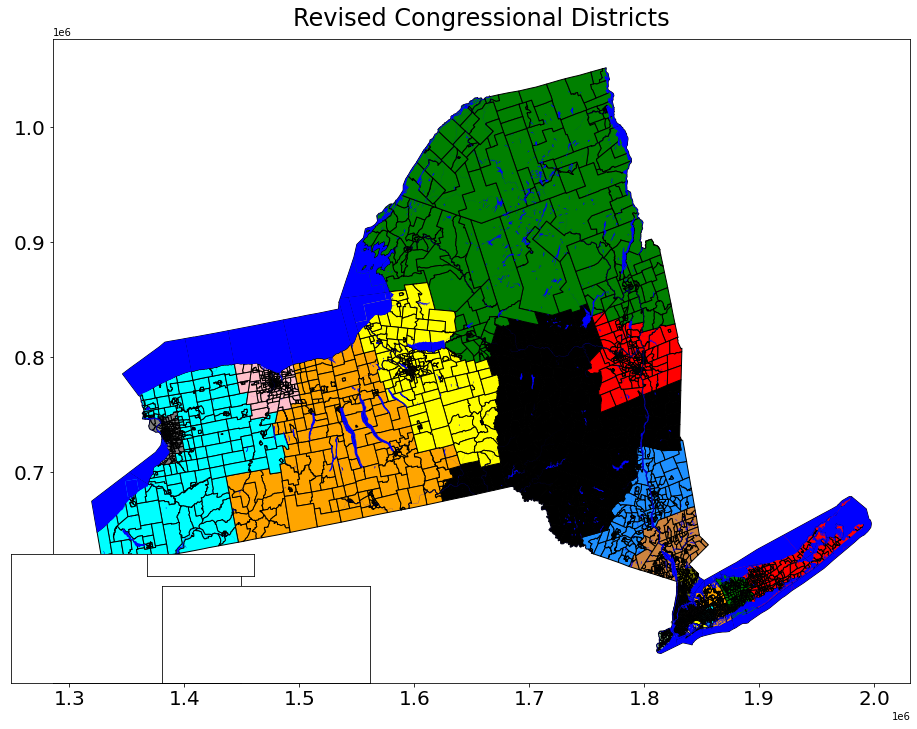

Done plotting in 43 seconds!


In [18]:
s = time.time()
main_map_crs = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs "

alaska_crs = "epsg:3338"
hawaii_crs = "+proj=tmerc +lat_0=21.16666666666667 +lon_0=-158 +k=0.99999 +x_0=500000.0000000002 +y_0=0 +datum=NAD83 +units=us-ft +no_defs "


show_tracts = False
show_water = True

print('main map...')

print('\treprojecting...')

main_map_bounds = unary_union(state_gdf[state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).geometry.tolist()).bounds
main_map_aspect_ratio = (main_map_bounds[2] - main_map_bounds[0]) / (main_map_bounds[3] - main_map_bounds[1])

fig, ax = plt.subplots(1,1,figsize=(24, 24/main_map_aspect_ratio))
ax.set_aspect('equal')


print('\tplotting...')

for this_state in state_gdf[(state_gdf['STUSPS'].isin(these_states_dict.keys())) & (state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI']))]['STUSPS'].sort_values().tolist():
    print('\t\tPlotting {0:}...'.format(this_state))
    new_district_list = tract_gdf[(tract_gdf['STUSAB'] == this_state)]['new_district'].drop_duplicates().sort_values().tolist()
    for i in range(1, len(new_district_list)+1):
        tract_gdf[
            (tract_gdf['STUSAB'] == this_state) 
            & (tract_gdf['new_district'] == i)
        ].to_crs(main_map_crs).plot(ax=ax, color=district_color_cycle[i], edgecolor='black')
    

if (show_tracts):
    print('\tplotting census tracts...')
    tract_gdf[tract_gdf['STATEFP'].apply(lambda x: x not in [2,15])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

if (show_water):
    print('\tplotting census tracts...')
    water_gdf[water_gdf['STUSAB'].apply(lambda x: x not in ['AK','HI'])].to_crs(main_map_crs).plot(ax=ax, color='blue', edgecolor='none', linewidth=0.5)



    
#ax.legend(handles=legend_list, fontsize=10)

ax.set_title('Revised Congressional Districts', fontsize=24, y=1.01)

ax.tick_params(axis='both', labelsize=20)

# # # # # # print('saving figure...')
# # # # # # fig.savefig('{0:}{1:}_old.png'.format(script_dir, list(these_states_dict.keys())[0].lower()), format='png', dpi=300, bbox_inches='tight', facecolor='white')

# # # # #plt.show()
# # # e = time.time()
# # # g += (e-s)
# # # print('Done plotting in {0:.0f} minutes {1:.0f} seconds!'.format(np.floor((e-s)/60), (e-s)%60))
# # # #[inset['axes_position'][0], inset['axes_position'][1], inset['axes_size'][0], inset['axes_size'][1]]

# # # state_gdf[state_gdf['NAME'].apply(lambda x: x not in ['Alaska', 'Hawaii'])].to_crs(main_map_crs).plot(ax=ax)

print('AK inset...')
print('\treprojecting Alaska...')
ak_map_bounds = geopandas.GeoDataFrame(data=[[unary_union(county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAMELSAD'].apply(lambda x: 'aleutians west' not in x.lower()))].geometry.tolist())]], columns=['geometry'], crs=county_gdf.crs, geometry='geometry').to_crs(alaska_crs).bounds.values[0].tolist()
ak_map_aspect_ratio = (ak_map_bounds[2] - ak_map_bounds[0]) / (ak_map_bounds[3] - ak_map_bounds[1])

ak_inset_ax = ax.inset_axes([-0.049,0,ak_map_aspect_ratio*0.2,0.2])

#ak_inset_ax = ax.inset_axes([0,0,ak_map_aspect_ratio*1,1])

print('\t\treprojecting Aleutians West...')
aleutians_west_map_bounds = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Aleutians West')
].to_crs(alaska_crs).geometry.tolist()).bounds

aleutians_west_map_aspect_ratio = (aleutians_west_map_bounds[2] - aleutians_west_map_bounds[0]) / (aleutians_west_map_bounds[3] - aleutians_west_map_bounds[1])

# aleutians_inset_ax = ak_inset_ax.inset_axes([-0.325,-0.015,0.2*aleutians_west_map_aspect_ratio,0.2])   # to show Aletuians West in their actual geographic spot
aleutians_inset_ax = ak_inset_ax.inset_axes([0.59,0.825,0.175*aleutians_west_map_aspect_ratio,0.175])

print('plotting Alaska...')
new_district_list = tract_gdf[(tract_gdf['STUSAB'] == 'AK')]['new_district'].drop_duplicates().sort_values().tolist()
for i in range(1, len(new_district_list)+1):
    geopandas.overlay(
        tract_gdf[(tract_gdf['STUSAB'] == 'AK') & (tract_gdf['new_district'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=ak_inset_ax, color=district_color_cycle[i], edgecolor='black')
    geopandas.overlay(
        tract_gdf[(tract_gdf['STUSAB'] == 'AK') & (tract_gdf['new_district'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] == 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=aleutians_inset_ax, color=district_color_cycle[i], edgecolor='black')
# if (show_tracts):
#     print('\tplotting census tracts...')
#     tract_gdf[tract_gdf['STUSAB'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)
    

print('HI inset...')
print('\treprojecting and plotting Hawaii...')
print('\t\tremoving outer islands...')
honolulu_county_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Honolulu')
].geometry.tolist())
honolulu_county_bounds = honolulu_county_geo.bounds
fixed_honolulu_county_geo = unary_union(geopandas.overlay(
    geopandas.GeoDataFrame(data=[[honolulu_county_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'), 
    geopandas.GeoDataFrame(data=[[box(-160, honolulu_county_bounds[1], honolulu_county_bounds[2], honolulu_county_bounds[3])]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'),
    how='intersection'
).geometry.tolist())
other_hawaii_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] != 'Honolulu')
].geometry.tolist())
fixed_hawaii_geo = unary_union([other_hawaii_geo, fixed_honolulu_county_geo])
fixed_hawaii_gdf = geopandas.GeoDataFrame(data=[[fixed_hawaii_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry')

hi_map_bounds = fixed_hawaii_gdf.geometry.to_crs(hawaii_crs).geometry.apply(lambda x: x.bounds).values[0]
hi_map_aspect_ratio = (hi_map_bounds[2] - hi_map_bounds[0]) / (hi_map_bounds[3] - hi_map_bounds[1])

#print(hi_map_aspect_ratio)

hi_inset_ax = ax.inset_axes([0.128,0,hi_map_aspect_ratio*0.15,0.15])

print('plotting Hawaii...')
new_district_list = tract_gdf[(tract_gdf['STUSAB'] == 'HI')]['new_district'].drop_duplicates().sort_values().tolist()
for i in range(1, len(cdlist)+1):
    geopandas.overlay(
        tract_gdf[(tract_gdf['STUSAB'] == 'HI') & (tract_gdf['new_district'] == i)], 
        fixed_hawaii_gdf,
        #county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(hawaii_crs).plot(ax=hi_inset_ax, color=district_color_cycle[i], edgecolor='black')

### Check RI
# ax.set_xlim([1.9e6, 2.2e6])
# ax.set_ylim([.7e6, .9e6])

for thisax in [ak_inset_ax, aleutians_inset_ax, hi_inset_ax]: #[ax, ak_inset_ax, aleutians_inset_ax, hi_inset_ax]:
    thisax.set_xticks([])
    thisax.set_yticks([])

plt.show()
# print('saving figure...')
# fig.savefig(script_dir+'new-districts-11.jpg', format='jpg', dpi=300, bbox_inches='tight')
e = time.time()
g += (e-s)
print('Done plotting in {0:,.0f} seconds!'.format(e-s))


In [19]:
s = time.time()
tract_gdf['new_district'].to_csv(script_dir+'new-districts-26-new-york.csv')
e = time.time()
g += (e-s)
print('Classified and saved {0:,.0f} in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf), np.floor((e-s)/60), (e-s)%60))
print('\n')
print('TOTAL TIME: {0:,.0f} minutes {1:,.0f} seconds!'.format( np.floor(g/60), g%60))

Classified and saved 5,411 in 0 minutes 0 seconds!


TOTAL TIME: 4 minutes 14 seconds!


In [20]:
# NEW YORK

In [21]:

# 	NAME	POP100
# GEOID		
# 35620	New York-Newark-Jersey City, NY-NJ-PA	13166338.0
# 15380	Buffalo-Cheektowaga, NY	1166902.0
# 40380	Rochester, NY	1090135.0
# 10580	Albany-Schenectady-Troy, NY	899262.0
# 39100	Poughkeepsie-Newburgh-Middletown, NY	697221.0
# 45060	Syracuse, NY	662057.0
# 46540	Utica-Rome, NY	292264.0
# 13780	Binghamton, NY	247138.0
# 28740	Kingston, NY	181851.0
# 27460	Jamestown-Dunkirk-Fredonia, NY	127657.0
# 24020	Glens Falls, NY	127039.0
# 48060	Watertown-Fort Drum, NY	116721.0
# 36300	Ogdensburg-Massena, NY	108505.0
# 27060	Ithaca, NY	105740.0
# 18500	Corning, NY	93584.0
# 21300	Elmira, NY	84148.0
# 38460	Plattsburgh, NY	79843.0
# 36460	Olean, NY	77042.0
# 12180	Auburn, NY	76248.0
# 26460	Hudson, NY	61570.0
# 36580	Oneonta, NY	58524.0
# 12860	Batavia, NY	58388.0


### NYC METRO AREA
#bounds_counties = ['New York', 'Kings', 'Queens', 'Bronx', 'Richmond']
#bounds_counties += ['Nassau', 'Suffolk', 'Westchester']
#bounds_counties += ['Rockland', 'Putnam', 'Orange']

### BUFFALO METRO AREA
#bounds_counties = ['Erie', 'Niagara']

### ROCHESTER METRO AREA
#bounds_counties = ['Monroe', 'Livingston', 'Ontario', 'Orleans', 'Wayne', 'Yates']

### ALBANY METRO AREA
#bounds_counties = ['Albany', 'Saratoga', 'Schenectady', 'Rensselaer']


### SYRACUSE METRO AREA
#bounds_counties = ['Onondaga', 'Oswego', 'Madison', 'Cayuga', 'Cortland']


In [22]:
######## NEW YORK ##########


# places_for_bounds = ['Chicago']
# xlimits = [unary_union(place_gdf[place_gdf['NAME'].isin(places_for_bounds)].to_crs(main_map_crs).geometry.tolist()).bounds[0], unary_union(place_gdf[place_gdf['NAME'].isin(places_for_bounds)].to_crs(main_map_crs).geometry.tolist()).bounds[2]]
# ylimits = [unary_union(place_gdf[place_gdf['NAME'].isin(places_for_bounds)].to_crs(main_map_crs).geometry.tolist()).bounds[1], unary_union(place_gdf[place_gdf['NAME'].isin(places_for_bounds)].to_crs(main_map_crs).geometry.tolist()).bounds[3]]

#### Lower Manhattan
# xlimits = [1.825e6,1.829e6]
# ylimits = [570000,580000]

#### North Bronx
# xlimits = [1.828e6,1.832e6]
# ylimits = [592000,596000]

#### West central Bronx
# xlimits = [1.83e6,1.8365e6]
# ylimits = [587000,595000]

### SE Brooklyn
# xlimits = [1.823e6,1.83e6]
# ylimits = [558000,570000]

### S Coast of Brooklyn
# xlimits = [1.827e6,1.836e6]
# ylimits = [555700,561300]

### SE Inland Brooklyn
# xlimits = [1.827e6, 1.8325e6]
# ylimits = [555000,567000]


### Brooklyn: Park Slope / Downtown / Navy Yard
# xlimits = [1.827e6, 1.832e6]
# ylimits = [565000,573000]


### Brooklyn: Flatbush
# xlimits = [1.831e6,1.839e6]
# ylimits = [555900,567900]

### Brooklyn: Williamsburg
# xlimits = [1.828e6,1.835e6]
# ylimits = [571000,576000]


### All of District 8
# xlimits = [1.829e6,1.839e6]
# ylimits = [568000,577000]

########### N Queens
# xlimits = [1.83e6, 1.845e6]
# ylimits = [576000, 586000]


########### W Queens
# xlimits = [1.829e6, 1.84e6]
# ylimits = [570000, 582000]


########### Far W Queens
# xlimits = [1.829e6, 1.834e6]
# ylimits = [575000, 582000]


########### WSW Queens
# xlimits = [1.833e6, 1.838e6]
# ylimits = [571000, 576500]



########### Central-west Queens
# xlimits = [1.834e6, 1.848e6]
# ylimits = [572500, 582000]


########### Central Queens
# xlimits = [1.837e6, 1.85e6]
# ylimits = [579000,584000]


########### NW Central Queens zoom
# xlimits = [1.838e6, 1.842e6]
# ylimits = [579000,584000]


#### Between 495 and 25
# xlimits = [1.839e6,1.849e6]
# ylimits = [575000,579000]

#### Between 495 and 25 (closer to 25)
# xlimits = [1.839e6,1.846e6]
# ylimits = [575500,579000]

#### Between 25 and 24 in far NE Queens
# xlimits = [1.846e6, 1.85e6]
# ylimits = [576000, 584000]

########### Central-west Queens south of 25
# xlimits = [1.834e6, 1.84e6]
# ylimits = [574500, 577000]

### Central Queens south of 25
# xlimits = [1.84e6, 1.845e6]
# ylimits = [574500, 576800]


#### South-central Queens
# xlimits = [1.837e6, 1.844e6]
# ylimits = [565000, 575000]


#### East Queens
# xlimits = [1.843e6, 1.85e6]
# ylimits = [568000, 581000]


### SW Nassau County
# xlimits = [1.847e6, 1.864e6]
# ylimits = [560000,585000]

### W Suffolk County
# xlimits = [1.86e6, 1.91e6]
# ylimits = [580000, 620000]

### Islip area
# xlimits = [1.876e6,1.894e6]
# ylimits = [585000,615000]


### Garden City area
# xlimits = [1.845e6, 1.86e6]
# ylimits = [575000,590000]



########### N Queens
# xlimits = [1.83e6, 1.845e6]
# ylimits = [576000, 586000]

##### SSW Queens
# xlimits = [1.833e6, 1.837e6]
# ylimits = [570000, 579000]


### ENE Queens
# xlimits = [1.836e6,1.846e6]
# ylimits = [579000,583000]

##### Far W Queens
# xlimits = [1.834e6,1.837e6]
# ylimits = [575000,581000]

##### Queens across from Roosevelt Island
# xlimits = [1.829e6,1.832e6]
# ylimits = [578000,582000]


#### West central Bronx
# xlimits = [1.83e6,1.8365e6]
# ylimits = [587000,595000]


#### West central Bronx coast
# xlimits = [1.829e6,1.833e6]
# ylimits = [588000,591000]



#### S Westchester / N Bronx
# xlimits = [1.83e6, 1.845e6]
# ylimits = [592000, 602000]


#### North-central Bronx
# xlimits = [1.831e6, 1.837e6]
# ylimits = [593000, 597000]


#### South-central Westchester
# xlimits = [1.825e6, 1.85e6]
# ylimits = [602000, 620000]


In [23]:
#tract_gdf.head(1).T